In [2]:
import os
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import MultipleLocator, ScalarFormatter
from tqdm import tqdm
# from joblib import Parallel, delayed
import warnings
warnings.simplefilter(action='ignore', category=Warning)

In [3]:
# Настройка рабочего стола и вывода инфы в пандас
from IPython.display import display, HTML
display(HTML("<style>.container { width:98% !important; }</style>"))
pd.options.display.max_columns = 15
pd.options.display.precision = 7
pd.options.display.max_colwidth = 200
pd.options.display.max_rows = 200

## Скрипт для чтения и конкатенации указанного листа в эксель-файле по определенным месяцам

In [4]:
def getDataXlsReport(path_month = '2023_Jan', work_type = 0):
    '''
    path_month = [2022_Sep, 2022_Oct ... 2023_Apr]
    work_type = [0: бурение, 1:ВНС, 2:ЗБС, 3:отказы]
    '''
    path_server = r'\\10.62.176.27\PetroEngineering_1\Петроинжиниринг\01. ННГ\14. КонтролСкважины Отчеты\\'
    filePath = os.path.join(path_server, path_month)
    dfs = list()
    for file in os.listdir(filePath):
        if 'short' in file:
            fileName = os.path.join(filePath, file)
            xl_sheets = pd.ExcelFile(fileName)
            xl_sh_name = xl_sheets.sheet_names[work_type]
            dateRep ='-'.join(file.split('_')[2:]).split('.')[0]
            data = pd.read_excel(fileName, sheet_name = f'{xl_sh_name}')
            data['Дата'] = dateRep
            data['Вид отчета'] = xl_sh_name.split('_')[0]
            dfs.append(data)
            result = pd.concat(dfs, ignore_index=True)
    return result

In [5]:
zbs_month_3 = getDataXlsReport('2023_Mar', 2)
zbs_month_2 = getDataXlsReport('2023_Apr', 2)
zbs_month_1 = getDataXlsReport('2023_May', 2)
frames = [zbs_month_1, zbs_month_2, zbs_month_3]
data = pd.concat(frames)
zbsData = data.dropna(subset = ['Месторождение'], axis=0)
zbsData = zbsData.rename(columns={zbsData.columns[4]: 'отчет_6ч', zbsData.columns[5]: 'отчет_18ч'})
zbsData.iloc[:,0] = zbsData.iloc[:,0].str.lower()
convert_dict = {'Месторождение': 'string',
                'Скважина': 'string',
                'Куст': 'string',
                'Оборудование':'string', 
                'отчет_6ч': 'string',
                'отчет_18ч': 'string',
                'пар_раб_м3': 'float64',
                'пар_раб_%': 'float64',
                'Вид отчета': 'string'} 
zbsData = zbsData.astype(convert_dict)
zbsData['Дата'] = pd.to_datetime(zbsData['Дата'], format ='%Y-%m-%d-%H-%M')

## Проверка названий месторождений и создание колонки uwi

In [6]:
zbsData['Месторождение'].unique()

<StringArray>
[          'сугмутское',       'вынгапуровское',        'вынгаяхинское',
         'суторминское',          'карамовское',      'средне-итурское',
          'ярайнерское',              'крайнее',      'малопякутинское',
         'спорышевское',      'южно-ноябрьское',           'новогоднее',
 'восточно-пякутинское',   'вынгапуровское (2)',   'вынгапуровское (3)',
       'новогоднее (2)',     'спорышевское (2)',      'ярайнерское (2)',
  'средне-итурское (1)',   'вынгапуровское (1)',      'карамовское (1)',
   'вынгапуровское (5)']
Length: 22, dtype: string

In [7]:
# Ячейка для переименование месторождений, если в предыдущей ячеки видны битые названия
zbsData['Месторождение'] = zbsData.iloc[:,0].replace('вынгапуровское (2)', 'вынгапуровское')
zbsData['Месторождение'] = zbsData.iloc[:,0].replace('вынгапуровское (3)', 'вынгапуровское')
zbsData['Месторождение'] = zbsData.iloc[:,0].replace('новогоднее (2)', 'новогоднее')
zbsData['Месторождение'] = zbsData.iloc[:,0].replace('спорышевское (2)', 'спорышевское')
zbsData['Месторождение'] = zbsData.iloc[:,0].replace('ярайнерское (2)', 'ярайнерское')
zbsData['Месторождение'] = zbsData.iloc[:,0].replace('средне-итурское (1)', 'средне-Итурское')
zbsData['Месторождение'] = zbsData.iloc[:,0].replace('вынгапуровское (1)', 'вынгапуровское')
zbsData['Месторождение'] = zbsData.iloc[:,0].replace('карамовское (1)', 'карамовское')
zbsData['Месторождение'] = zbsData.iloc[:,0].replace('вынгапуровское (5)', 'вынгапуровское')
zbsData['Месторождение'] = zbsData.iloc[:,0].replace('средне-Итурское', 'средне-итурское')

In [8]:
zbsData['Месторождение'].unique()

<StringArray>
[          'сугмутское',       'вынгапуровское',        'вынгаяхинское',
         'суторминское',          'карамовское',      'средне-итурское',
          'ярайнерское',              'крайнее',      'малопякутинское',
         'спорышевское',      'южно-ноябрьское',           'новогоднее',
 'восточно-пякутинское']
Length: 13, dtype: string

In [9]:
zbsData['uwi'] = zbsData.iloc[:,0] + '_' + zbsData.iloc[:,1] #собираем uwi здесь т.к. названия месторождений еще переименовываются

## Если мы хотим историю скважины, это можно сделать здесь

In [10]:
# zbsData[zbsData['Скважина']=='1758'].sort_values(by=['Дата']).to_excel('test.xlsx')

## Загрузка координат скважин из Состояние фонда

In [11]:
wi_nng_init = pd.read_csv('wi_nng.csv', encoding='1251', sep=';', engine = 'python')
wi_mur_init = pd.read_csv('wi_mur.csv', encoding='1251', sep=';', engine = 'python')
wi_nng = wi_nng_init.iloc[:, [0,1,2,3,4,5,6,7,10,12,13]]
wi_mur = wi_mur_init.iloc[:, [0,1,2,3,4,5,6,7,10,12,13]]
wi_nng['ДО'] = 'nng'
wi_mur['ДО'] = 'mur'
wi_total = pd.concat([wi_nng, wi_mur])
convert_dict = {'FIELD': 'string',
                'UWI': 'string',
                'КУСТ': 'string',
                'ИМЯ_NGT': 'string',
                'УСТЬЕ_X': 'float64',
                'УСТЬЕ_Y': 'float64',
                'СТАТУС_СКВАЖИНЫ': 'string',
                'ИМЯ_NGT': 'string',
                'СИСТЕМА_КООРДИНАТ': 'string',
                'ДО': 'string',
               } 
wi_total = wi_total.astype(convert_dict)
wi_total.FIELD = wi_total.FIELD.str.lower()
# wi_total.UWI.str.split('_', expand=True).iloc[:,1]
# wi_total = wi_total.join(wi_total.UWI.str.split('_', expand=True).iloc[:,1])
# wi_total.rename(columns = {1:'Скважина'}, inplace=True)
wi_total['uwi'] = wi_total.iloc[:,0] + '_' + wi_total.iloc[:,9]
wi_total_copy = wi_total.iloc[:,[0,2,3,4,5,6,7,9,10,11,12]]

## Джойним ЗБС из отчета и таблицу координат скважин. Проверяем все ли скважины получили координаты

In [12]:
zbsData_copy = zbsData[['Месторождение', 'Скважина', 'Куст', 'Оборудование','пар_раб_м3', 'пар_раб_%', 'пар_раб_тн', 'Дата', 'uwi']]
zbsData_copy = zbsData_copy.join(wi_total_copy.set_index('uwi'), on = 'uwi')
zbsData_copy.sample(3)

,Месторождение,Скважина,Куст,Оборудование,пар_раб_м3,пар_раб_%,пар_раб_тн,...,УСТЬЕ_Y,Х_ЗАБОЙ,Y_ЗАБОЙ,ТИП_СКВАЖИНЫ,ИМЯ_NGT,СИСТЕМА_КООРДИНАТ,ДО
869,суторминское,4685,96,"Конструкция скважины: Э/к-146(0-2770м)_x000D_ хв-102(2471,48-3707м)_x000D_ Ю2 Муфты ГРП_x000D_ и.з.-3706,3м т.з.-3706,3м_x000D_ ГРП: 4 порт - 3427,68м(+)195,4м3/71тн/23.04.23_x000D_ 3 порт(+)196м...",NaN,NaN,NaN,...,7057012.376,475227.2702,7056483.766,Эксплуатационная скважина,4685,UTM-43,mur
294,вынгаяхинское,2492,153,"Конструкция скважины: Проект.пласт БП16. Т1-3249м. Т3-3443м. инт.окна 2416-2419м. Э/к-168(0-3062м)_x000D_ хв-114(2336,14-3437м)...",NaN,NaN,NaN,...,7082264.090,596175.6800,7081218.190,Эксплуатационная скважина,2492,UTM-43,mur
1001,карамовское,683,50,"Конструкция скважины: Э/к-146(0-3075м)_x000D_ хв-114(2413,22-3943м)_x000D_ Ач3(3896-3904м)_x000D_ Ач1(3910-3920м)_x000D_ и.з.-3942,5м т.з.-н/д",4.8,100.0,0.0,...,7021558.913,471820.8759,7020924.723,Эксплуатационная скважина,683,UTM-43,nng


## Проверка отсутствия координат у ЗБС-скважин

In [13]:
zbsData_copy_check_wells = zbsData_copy[zbsData_copy['Х_ЗАБОЙ'].isna()][['Месторождение', 'Скважина','uwi','Куст', 'пар_раб_м3','пар_раб_%', 'пар_раб_тн','Х_ЗАБОЙ', 'Y_ЗАБОЙ']]
zbsData_copy_check_wells = zbsData_copy_check_wells.drop_duplicates(subset=['uwi'])
zbsData_copy_check_wells

,Месторождение,Скважина,uwi,Куст,пар_раб_м3,пар_раб_%,пар_раб_тн,Х_ЗАБОЙ,Y_ЗАБОЙ
2,вынгапуровское,1253,вынгапуровское_1253,67,120.0,98.5,1.5,NaN,NaN
20,вынгапуровское,4520,вынгапуровское_4520,436,NaN,NaN,NaN,NaN,NaN
139,вынгапуровское,1561,вынгапуровское_1561,344,NaN,NaN,NaN,NaN,NaN
177,вынгапуровское,5142,вынгапуровское_5142,517,NaN,NaN,NaN,NaN,NaN


In [14]:
zbsData_copy_check_wells['uwi'].unique()

<StringArray>
['вынгапуровское_1253', 'вынгапуровское_4520', 'вынгапуровское_1561',
 'вынгапуровское_5142']
Length: 4, dtype: string

In [15]:
# Проверка нейминга скважин по таблице координат
checkLst = []
for well_check in zbsData_copy_check_wells['uwi']:
    checkLst.append(wi_total_copy[wi_total_copy['uwi'].str.contains(well_check)])
    result_well_check = pd.concat(checkLst, ignore_index=True)
result_well_check

,FIELD,КУСТ,УСТЬЕ_X,УСТЬЕ_Y,Х_ЗАБОЙ,Y_ЗАБОЙ,ТИП_СКВАЖИНЫ,ИМЯ_NGT,СИСТЕМА_КООРДИНАТ,ДО,uwi
0,вынгапуровское,67,593912.6299,6986367.226,594165.6199,6986121.396,Эксплуатационная скважина,1253f,UTM-43,nng,вынгапуровское_1253f
1,вынгапуровское,67,593912.6299,6986367.226,NaN,NaN,Эксплуатационная скважина,1253,UTM-43,nng,вынгапуровское_1253
2,вынгапуровское,436,587675.5058,6985017.466,587219.1498,6985298.129,Эксплуатационная скважина,4520f,UTM-43,nng,вынгапуровское_4520f
3,вынгапуровское,436,587675.5058,6985017.466,NaN,NaN,Эксплуатационная скважина,4520,UTM-43,nng,вынгапуровское_4520
4,вынгапуровское,344,595543.7000,6975023.800,595333.9100,6973043.030,Эксплуатационная скважина,1561f,UTM-43,nng,вынгапуровское_1561f
5,вынгапуровское,344,595543.7000,6975023.800,NaN,NaN,Эксплуатационная скважина,1561,UTM-43,nng,вынгапуровское_1561
6,вынгапуровское,344,595543.7000,6975023.800,595667.0000,6973505.100,Эксплуатационная скважина,1561PL,UTM-43,nng,вынгапуровское_1561PL
7,вынгапуровское,517,589525.5854,6978290.238,589304.5854,6978580.738,Эксплуатационная скважина,5142f,UTM-43,nng,вынгапуровское_5142f
8,вынгапуровское,517,589525.5854,6978290.238,NaN,NaN,Эксплуатационная скважина,5142,UTM-43,nng,вынгапуровское_5142


## Собираем датасет координат по эксплуатационным скважинам 

In [16]:
wi_total_map = wi_total_copy.dropna(subset=['СИСТЕМА_КООРДИНАТ'], axis=0)
wi_total_map_prod = wi_total_map[(wi_total_map['ТИП_СКВАЖИНЫ'] == 'Эксплуатационная скважина')]
wi_total_map_prod.sample(3)

,FIELD,КУСТ,УСТЬЕ_X,УСТЬЕ_Y,Х_ЗАБОЙ,Y_ЗАБОЙ,ТИП_СКВАЖИНЫ,ИМЯ_NGT,СИСТЕМА_КООРДИНАТ,ДО,uwi
12345,сугмутское,38,431771.2124,7073721.240,432722.0124,7073236.340,Эксплуатационная скважина,1927,UTM-43,mur,сугмутское_1927
7805,суторминское,111,482455.6505,7078387.673,482377.9205,7078004.753,Эксплуатационная скважина,8719,UTM-43,mur,суторминское_8719
2270,муравленковское,К-38Б,496034.6268,7105851.973,495999.0468,7105736.173,Эксплуатационная скважина,4050,UTM-43,mur,муравленковское_4050


## Функция для РегЭкспа колонки Оборудования и ее применение

In [17]:
# Убираем nan-значения из колонки пар_раб_м3
zbsData_map = zbsData_copy.dropna(subset=['пар_раб_м3'])

def regexp_zone(zbsData_diagramm):
    """
    Передается датафрейм, где должна быть колонка для РегЭксп с названием 'Оборудование'
    """
    regexpList = []
    for text in zbsData_diagramm['Оборудование']:
        try:
            match1 = re.findall('[0-9]{0,1}[АБСГПКВСЧЮ]{1,2}.[-+0-9/\//]+', text)
            match2 = re.findall('[Ю][0-9]', text)
            match3 = re.findall('Фильтр[0-9,-м()]+', text)
            if match1:
                regexpList.append(match1[0])
            elif match2:
                regexpList.append(match2[0])
            elif match3:
                regexpList.append(match3[0])
            else:
                regexpList.append("pattern not found")
        except:
            regexpList.append("Оборудование-string is empty")
    return regexpList 

zbsData_map['Пласт_збс'] = regexp_zone(zbsData_map)

In [18]:
# Проверка на pattern not found и Оборудование-string is empty
test_regexp = zbsData_map[['uwi', 'Оборудование','Пласт_збс']][(zbsData_map['Пласт_збс'] =='pattern not found') | (zbsData_map['Пласт_збс'] =='Оборудование-string is empty')]
test_regexp[~test_regexp.uwi.duplicated()]

,uwi,Оборудование,Пласт_збс
994,спорышевское_1094,<NA>,Оборудование-string is empty
365,вынгаяхинское_2114,"Конструкция скважины: 2 порт - 2796,50м_x000D_ 1 порт - 3032,31м_x000D_ Хвостовик_x000D_ ГРП: 3 порт - 2832,28м(+)197м3/70тн/11.03.23 _x000D_ 2 порт(+)198м3/70тн/09.03.23 _x000D_ 1 порт - 3032,31м...",pattern not found


## Герерируем и агрегируем общую таблицу по всем ЗБС

In [19]:
zbsData_pivot_ds = zbsData_map.groupby('uwi')['Дата'].apply(lambda x: x.iloc[0]).reset_index()
zbsData_pivot_ds.rename(columns = {'Дата':'Дата нач'}, inplace=True)
zbsData_pivot_df = zbsData_map.groupby('uwi')['Дата'].apply(lambda x: x.iloc[-1]).reset_index()
zbsData_pivot_df.rename(columns = {'Дата':'Дата фин'}, inplace=True)
zbsData_pivot_ds['Дата нач'] = zbsData_pivot_ds['Дата нач'].dt.strftime('%d/%m/%y')
zbsData_pivot_df['Дата фин'] = zbsData_pivot_df['Дата фин'].dt.strftime('%d/%m/%y')

zbsData_pivot = zbsData_map[['uwi','Месторождение', 'Скважина', 'Куст', 'Дата','Пласт_збс', 'пар_раб_м3','пар_раб_%', 'пар_раб_тн']]
plast_zbs = zbsData_map[['uwi','Пласт_збс']].groupby('uwi').apply(lambda x: x.iloc[0])
plast_zbs.drop('uwi', axis=1).reset_index()
zbsData_pivot_gb = zbsData_pivot.groupby('uwi').mean().round(0).reset_index()
zbsData_pivot_gb.rename(columns = {'пар_раб_м3':'ср жидкость м3',
                                  'пар_раб_%':'ср обводненность',
                                  'пар_раб_тн':'ср нефть тн'}, inplace=True)
zbsData_pivot_gb = zbsData_pivot_gb[['uwi', 'ср жидкость м3', 'ср нефть тн','ср обводненность']]
zbsData_pivot_gb = zbsData_pivot_gb.set_index('uwi').join(zbsData_pivot_ds.set_index('uwi')).reset_index()
zbsData_pivot_gb = zbsData_pivot_gb.set_index('uwi').join(zbsData_pivot_df.set_index('uwi')).reset_index()
zbsData_pivot_gb = zbsData_pivot_gb.set_index('uwi').join(plast_zbs.set_index('uwi')).reset_index()
zbsData_pivot_gb =zbsData_pivot_gb[['uwi','Дата нач','Дата фин', 'Пласт_збс','ср жидкость м3', 'ср нефть тн', 'ср обводненность']]
zbsData_pivot_gb

,uwi,Дата нач,Дата фин,Пласт_збс,ср жидкость м3,ср нефть тн,ср обводненность
0,восточно-пякутинское_6008,09/03/23,31/03/23,БС10-1,34.0,5.0,81.0
1,вынгапуровское_1182,04/05/23,31/05/23,БВ 8-1,210.0,16.0,88.0
2,вынгапуровское_1199,02/03/23,31/03/23,БВ 8-1,86.0,19.0,71.0
3,вынгапуровское_1252,18/04/23,30/04/23,БВ8/1,185.0,6.0,96.0
4,вынгапуровское_1253,01/04/23,31/03/23,БВ 8-1,163.0,6.0,96.0
5,вынгапуровское_1264,06/05/23,19/05/23,БВ8/1,125.0,27.0,73.0
6,вынгапуровское_1561,11/04/23,30/04/23,БВ-8,135.0,34.0,68.0
7,вынгапуровское_1833,24/03/23,31/03/23,БВ-8,91.0,13.0,84.0
8,вынгапуровское_1846,01/04/23,30/04/23,БВ8-1,109.0,23.0,75.0
9,вынгапуровское_2022,20/05/23,31/05/23,БВ 8-1,185.0,33.0,77.0


### Генерируем график из таблицы с разлением  на квадранты в поле координат "обводненность- ср нефть т"

In [20]:
colour = sns.choose_colorbrewer_palette("qualitative")

interactive(children=(Dropdown(description='name', options=('Set1', 'Set2', 'Set3', 'Paired', 'Accent', 'Paste…

In [21]:
# sns.histplot(data=zbsData_pivot_gb_v1, x="ср нефть тн", binwidth=4);

In [22]:
# sns.histplot(data=zbsData_pivot_gb_v1, x="ср обводненность", binwidth=1);

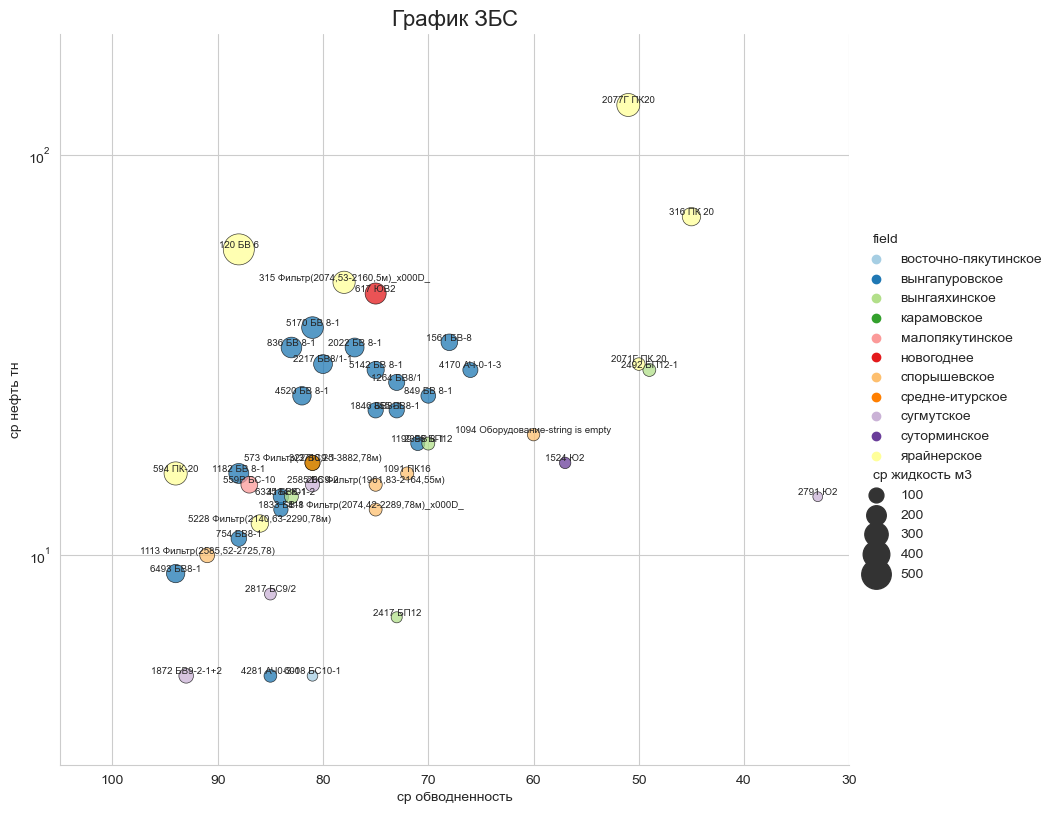

In [25]:
zbsData_pivot_gb_v1 = zbsData_pivot_gb.join(zbsData_pivot_gb.uwi.str.split('_', expand=True).iloc[:,0])
zbsData_pivot_gb_v1 = zbsData_pivot_gb_v1.join(zbsData_pivot_gb.uwi.str.split('_', expand=True).iloc[:,1])
zbsData_pivot_gb_v1.rename(columns={0:'field', 1:'well'}, inplace=True)
zbsData_pivot_gb_v1 = zbsData_pivot_gb_v1[(zbsData_pivot_gb_v1['ср нефть тн'] > 4) & (zbsData_pivot_gb_v1['ср обводненность'] < 96)]

sns.set_style("whitegrid")
fgrid = sns.relplot(data=zbsData_pivot_gb_v1, x='ср обводненность', y='ср нефть тн', hue='field', size='ср жидкость м3',
            sizes=(50,500), alpha=0.75, palette=colour, height=8,aspect=1.1, edgecolor='black',linewidth=0.5,linestyle='-')
ax = fgrid.axes[0][0]
ax.set_xlim(105, 30)
ax.set_ylim(3, 200)
ax.set_yscale('log')
ax.set_title('График ЗБС', fontsize=16)
for v in zbsData_pivot_gb_v1.iterrows():
    ax.annotate(v[1][8]+' '+v[1][3], (v[1][6],v[1][5]), (v[1][6], v[1][5]), fontsize = 7, ha='center',va='bottom');

## Отрисовка карт по скважинам из ЗБС и датасета координат

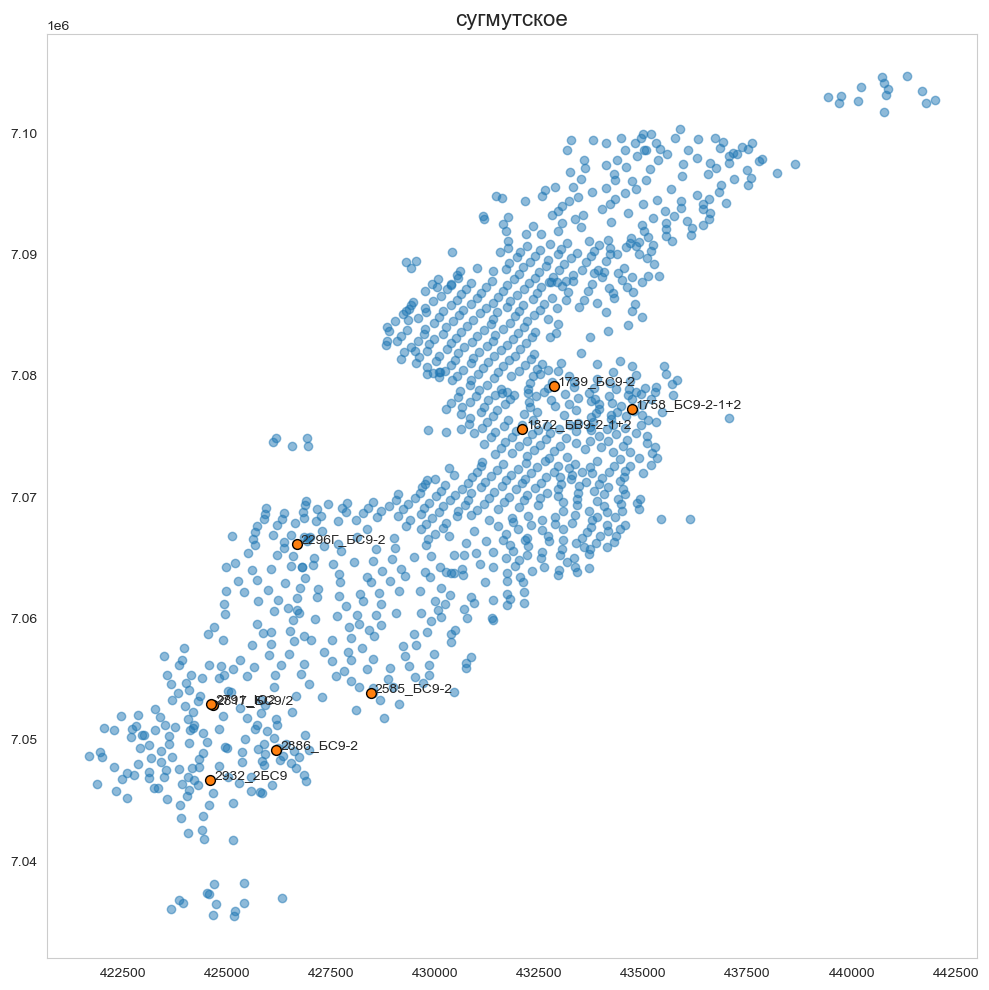

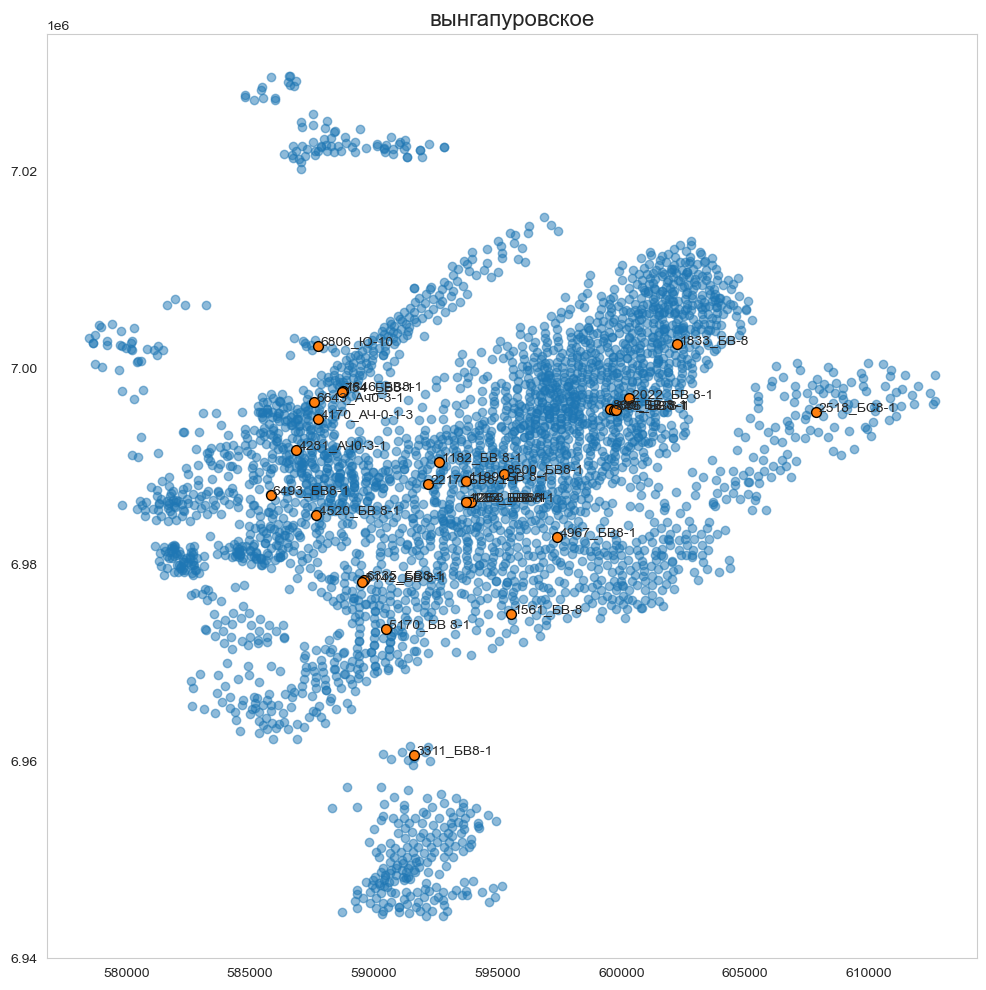

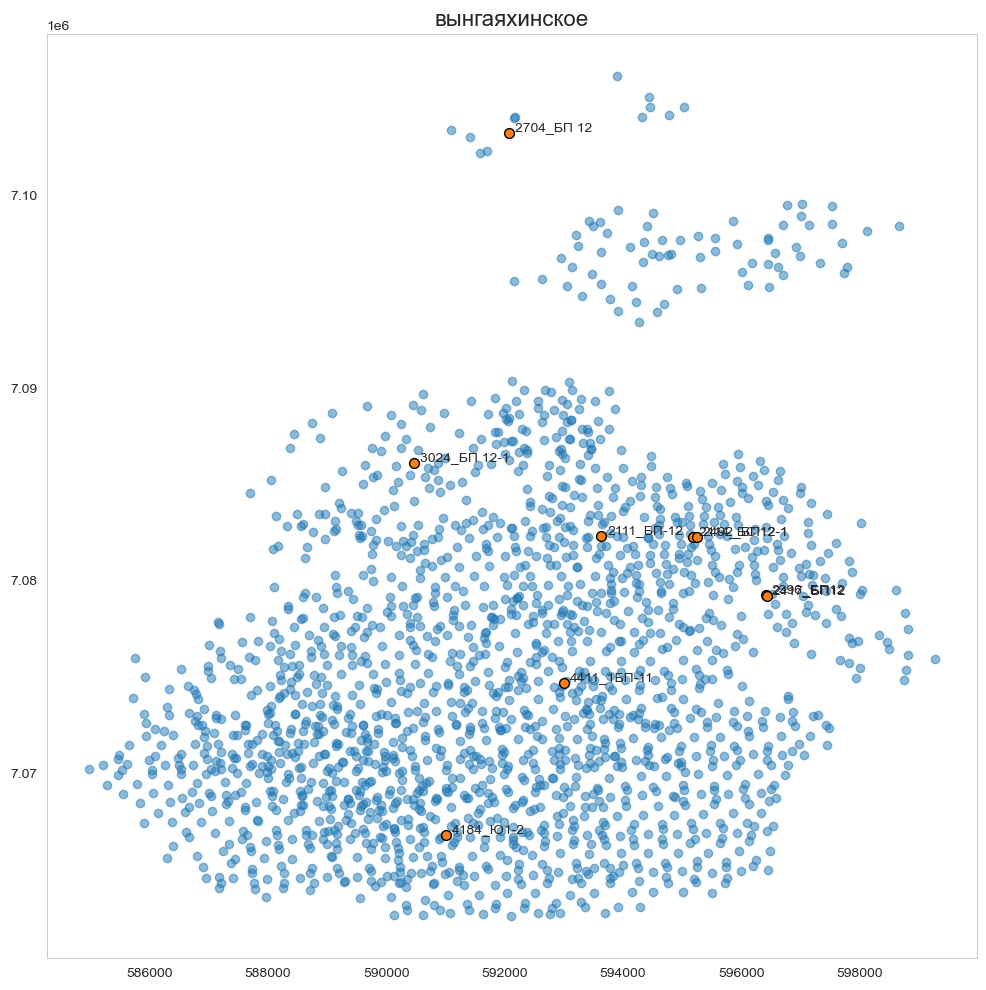

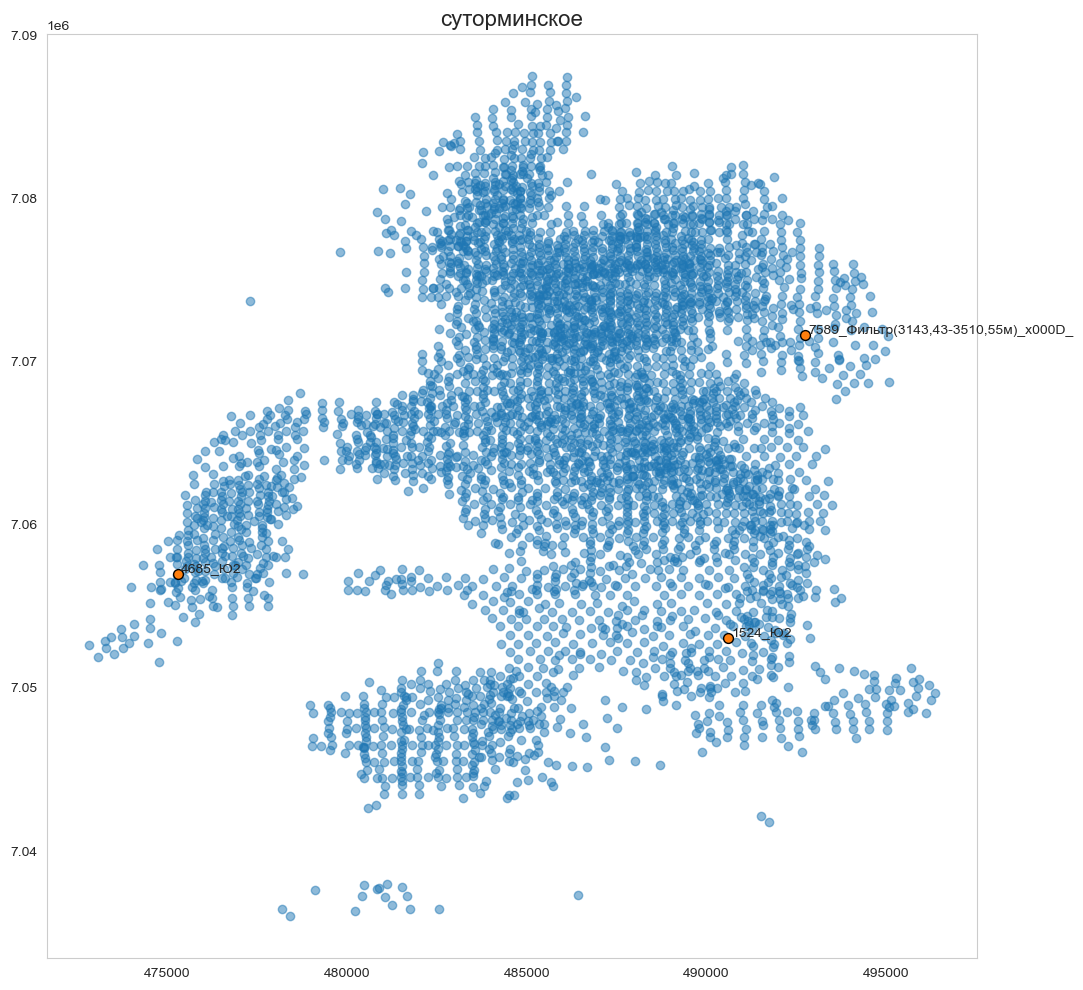

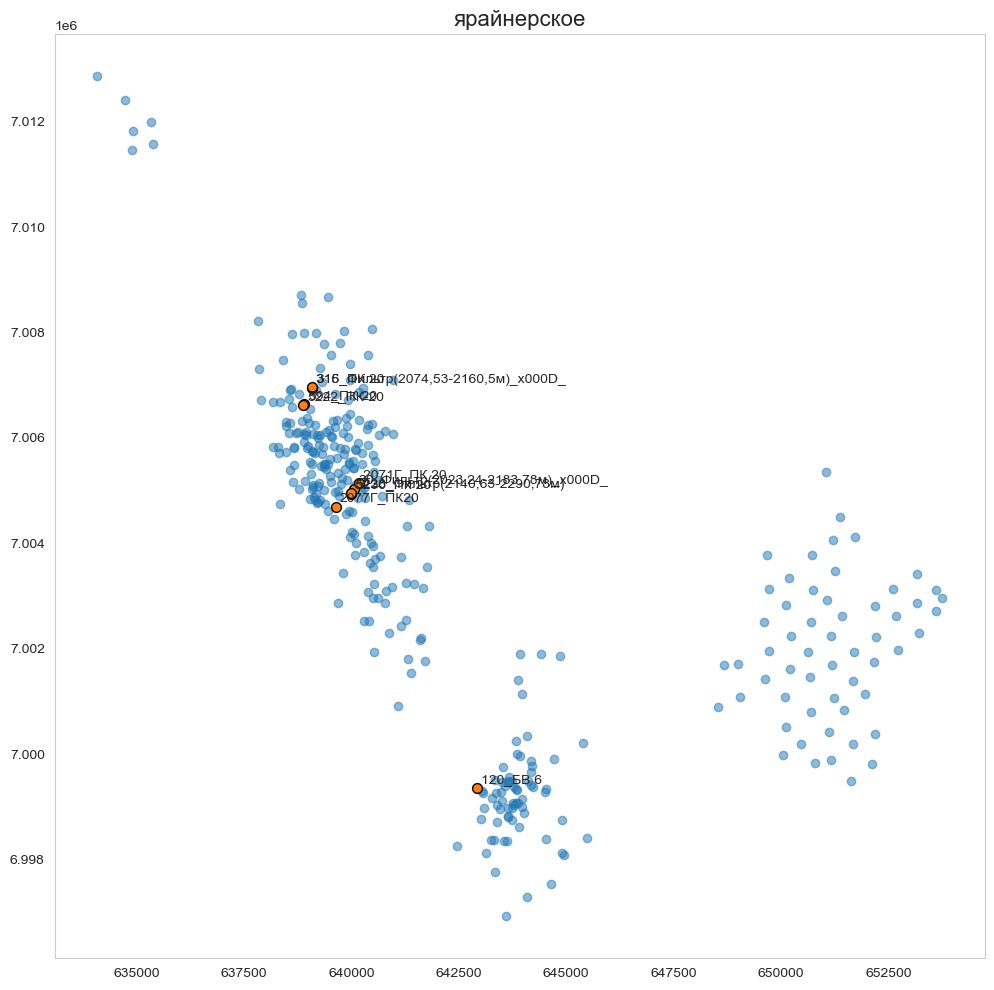

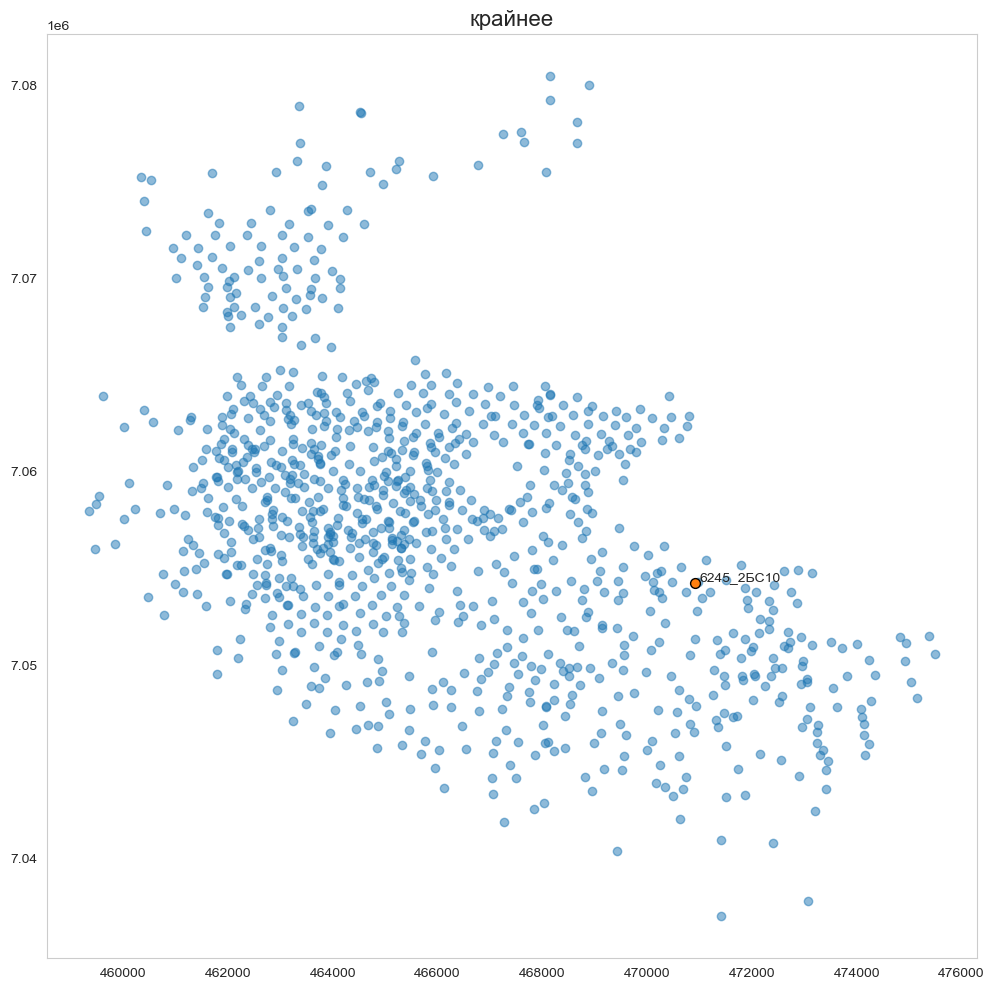

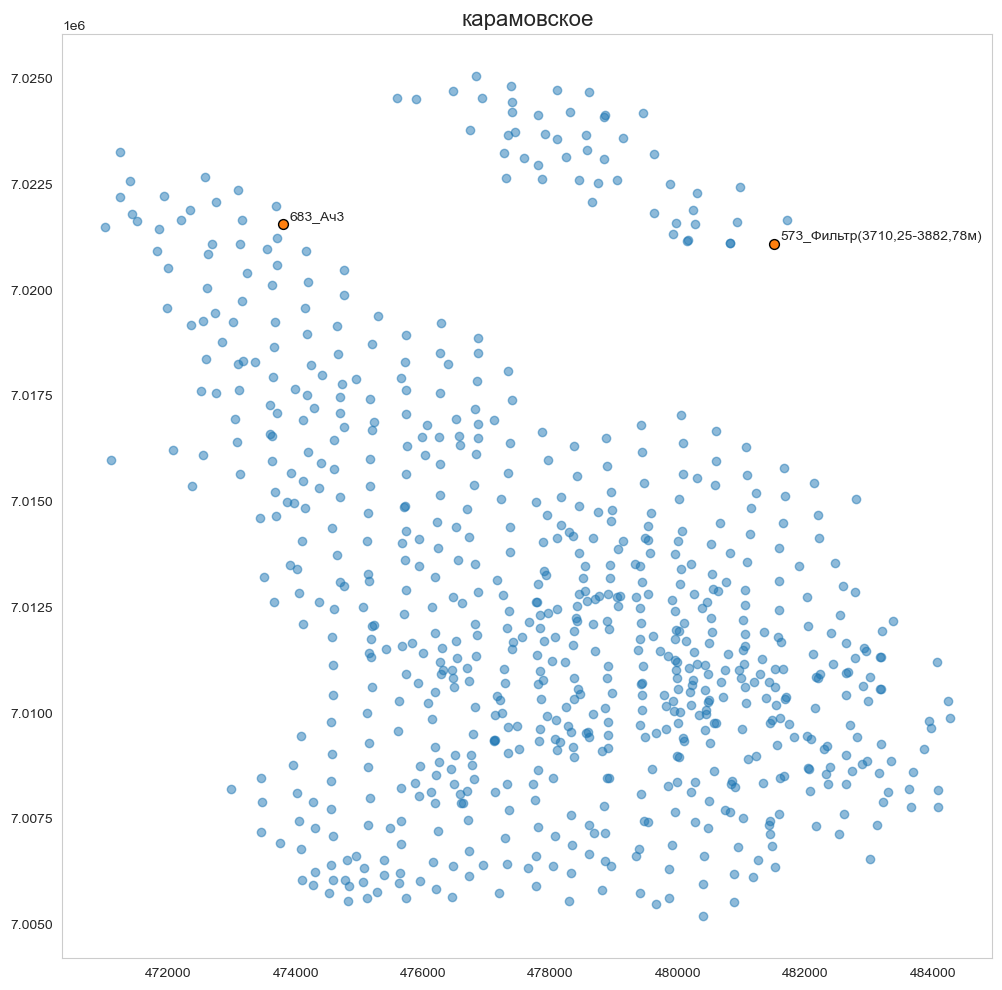

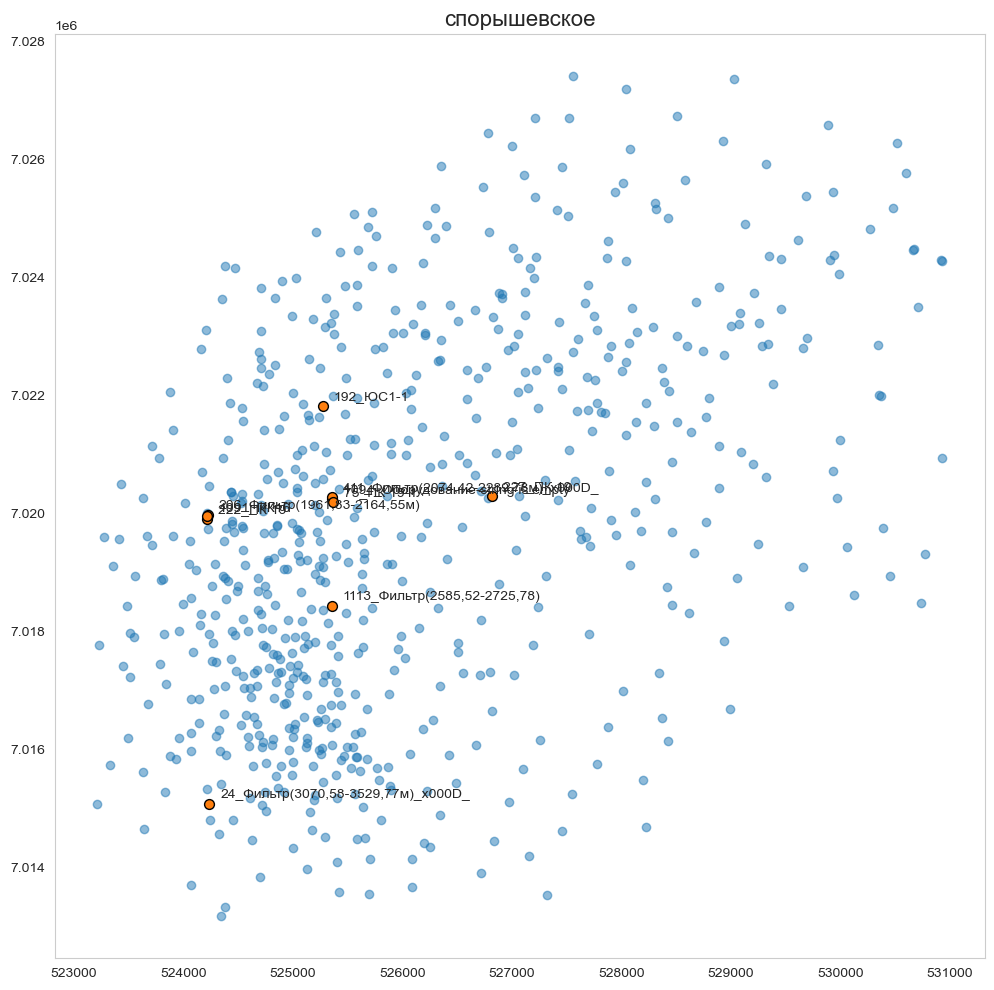

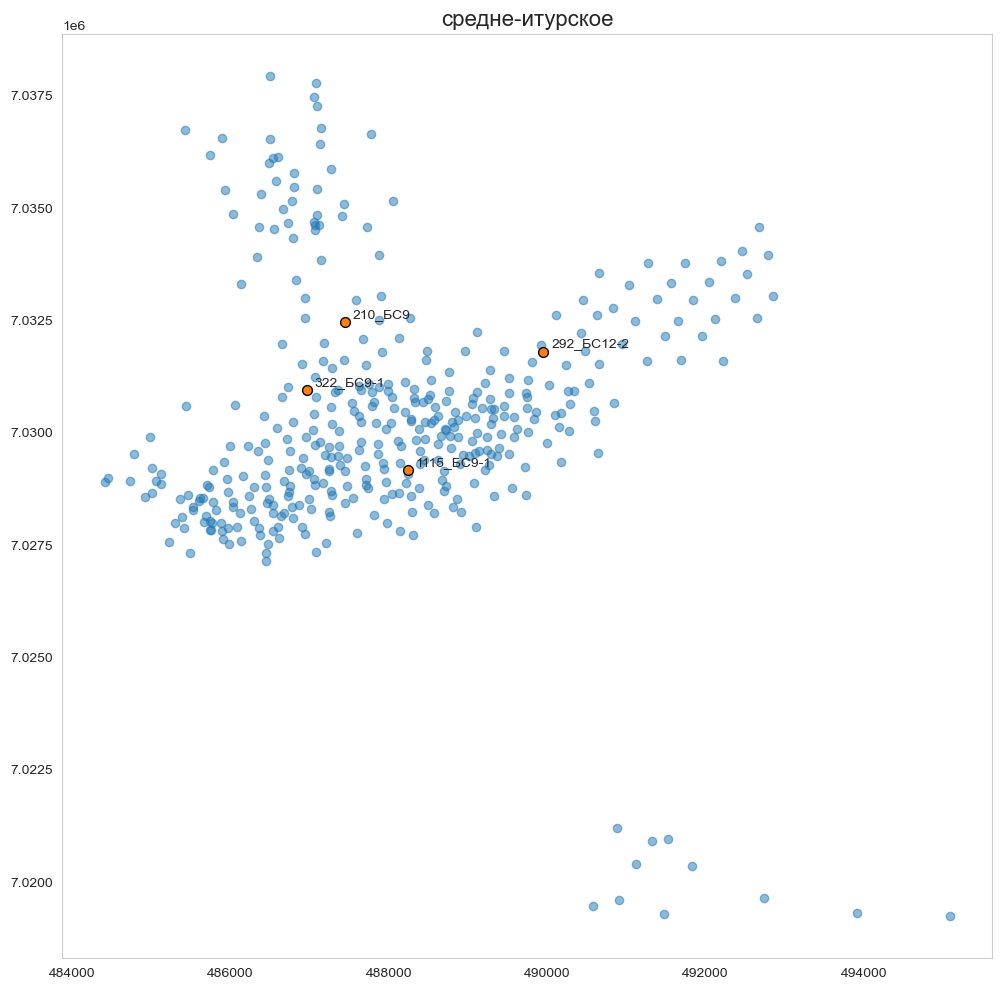

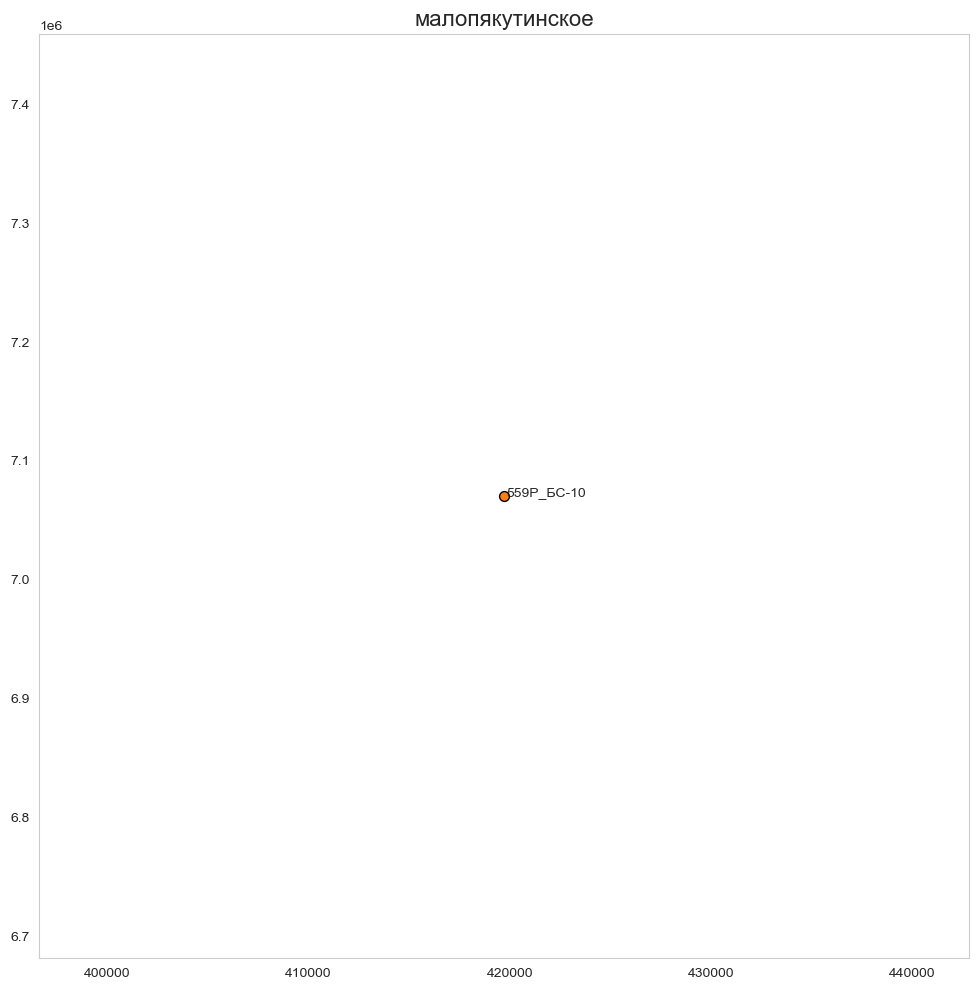

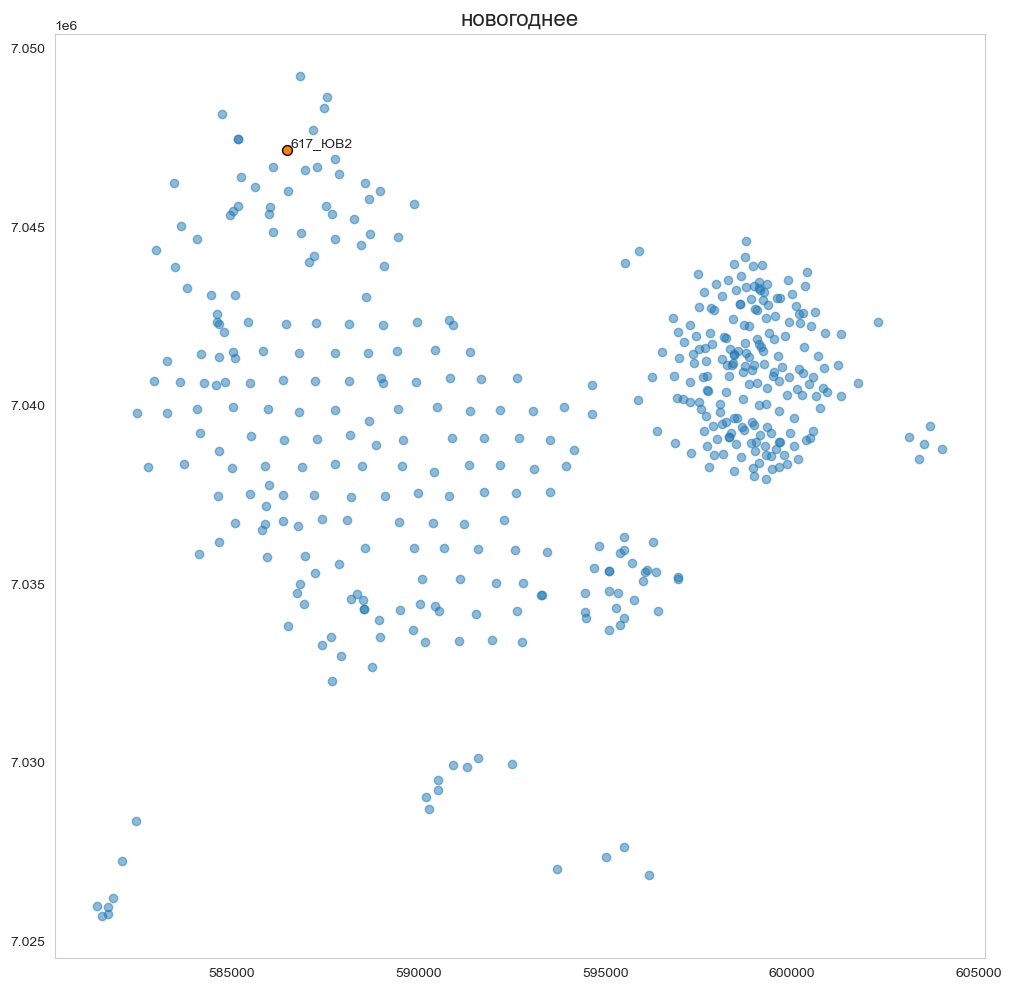

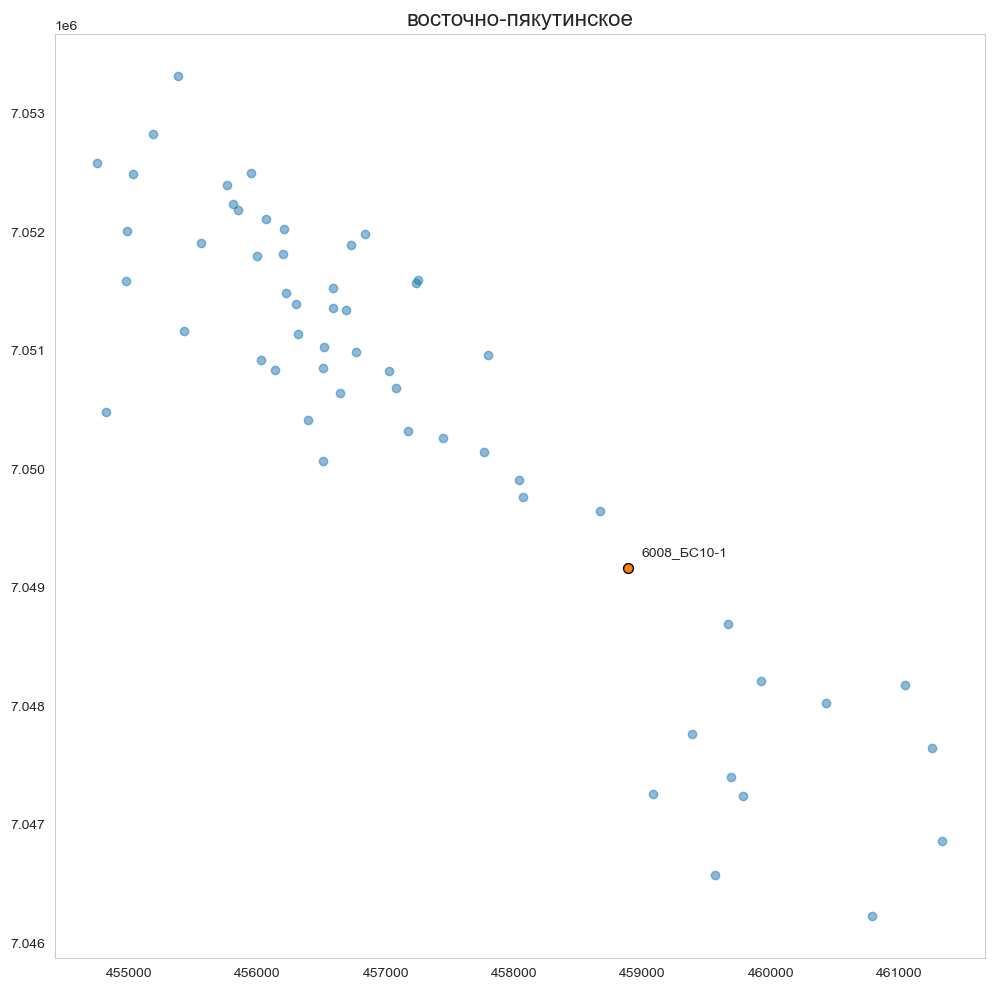

In [26]:
# %matplotlib qt
%matplotlib inline
oilfields_zbs = zbsData_map.iloc[:,0].unique()
for oilfield in oilfields_zbs[:]:
    f, ax = plt.subplots(figsize = (12,12))
    zbs_coord = zbsData_map[zbsData_map['Месторождение'] == oilfield].drop_duplicates(['uwi'], keep = 'first')
#     avg_prod = zbsData_map[zbsData_map['Месторождение'] == oilfield].groupby('Скважина')[['пар_раб_м3','пар_раб_%', 'пар_раб_тн']].mean()
#     well_good_list = list(avg_prod[avg_prod['пар_раб_тн'] > 15].reset_index()['Скважина'])
#     zbs_coord = zbs_coord[zbs_coord['Скважина'].isin(well_good_list)]
    well_coord = wi_total_map_prod[wi_total_map_prod['FIELD'] == oilfield]
    zbs_plast = zbs_coord['Пласт_збс']
    well_name = zbs_coord['Скважина']
    x_map = well_coord['Х_ЗАБОЙ']
    y_map = well_coord['Y_ЗАБОЙ']
    x_zbs = zbs_coord['УСТЬЕ_X']
    y_zbs = zbs_coord['УСТЬЕ_Y']
    ax.scatter(x_map,y_map, alpha=0.5)
    ax.scatter(x_zbs,y_zbs, s=50, ec='black')
    ax.set_title(oilfield, fontsize=16)
    ax.grid()
    for num, text in enumerate(zbs_coord['Пласт_збс']):
        ax.annotate(well_name.iloc[num] + '_' + text, (x_zbs.iloc[num]+100, y_zbs.iloc[num]+100), fontsize=10)
#     f.savefig(oilfield + '.pdf')

### Создание датасета для отображения диаграмм скважин с указанием месторождения

In [27]:
zbsData['Месторождение'].unique()
oilfield_wells = zbsData[zbsData['Месторождение'] == 'вынгапуровское']
oilfield_wells.dropna(subset=['пар_раб_м3', 'пар_раб_%', 'пар_раб_тн'], inplace=True, how='all')
oilfield_wells.sample(3)

,Месторождение,Скважина,Куст,Оборудование,отчет_6ч,отчет_18ч,пар_раб_м3,пар_раб_%,пар_раб_тн,Дата,Вид отчета,uwi
470,вынгапуровское,1199,62,"Конструкция скважины: Э/к-146(0-20м)_x000D_ Э/к-140(20-2682м)_x000D_ хв-102(2183,33-3129м)_x000D_ БВ 8-1 Муфты ГРП_x000D_ и.з.-3122,3м т.з.-н/д_x000D_ ГРП: 3 порт - 2925,84м(+)131м3/49тн/03.02.23...",в работе,в работе,77.0,75.15,15.631,2023-03-15 04:17:00,ЗБС,вынгапуровское_1199
1029,вынгапуровское,1199,62,"Конструкция скважины: Э/к-146(0-20м)_x000D_ Э/к-140(20-2682м)_x000D_ хв-102(2183,33-3129м)_x000D_ БВ 8-1 Муфты ГРП_x000D_ и.з.-3122,3м т.з.-н/д_x000D_ ГРП: 3 порт - 2925,84м(+)131м3/49тн/03.02.23...",в работе,в работе,63.0,50.00,25.732,2023-03-29 04:23:00,ЗБС,вынгапуровское_1199
548,вынгапуровское,754,30,"Конструкция скважины: Проект.пласт БВ8-1 Т1-3423,82м. Т3-3691м, инт.окна 2170-2173м. Э/к-146(0-2936,8м) хв-102(2093,42-3681м)_x000D_ БВ8-1 Муфты ГРП...",в работе,в работе,130.0,85.00,15.930,2023-03-17 16:27:00,ЗБС,вынгапуровское_754


### Отрисовка диаграмм скважин по указанному выше месторождению

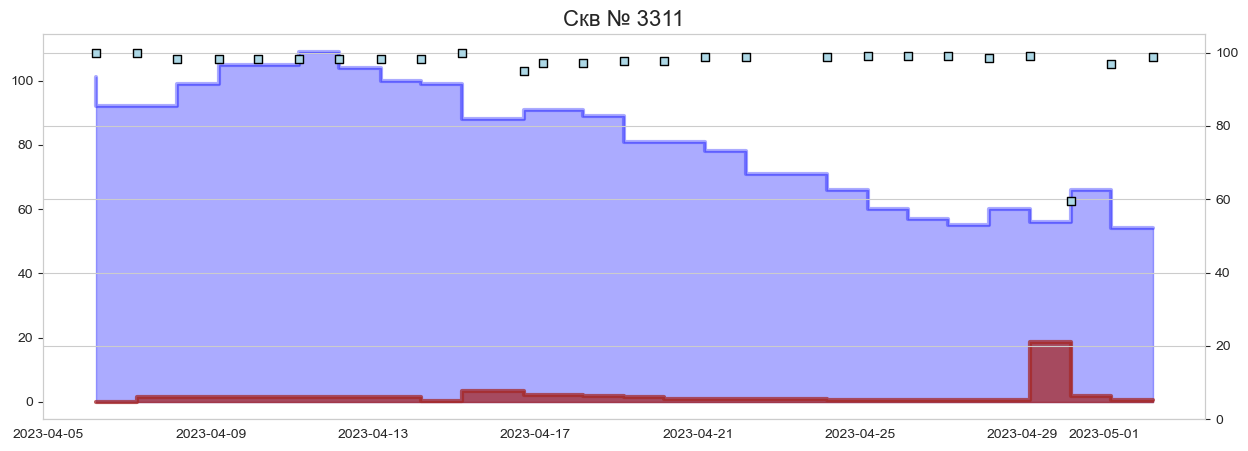

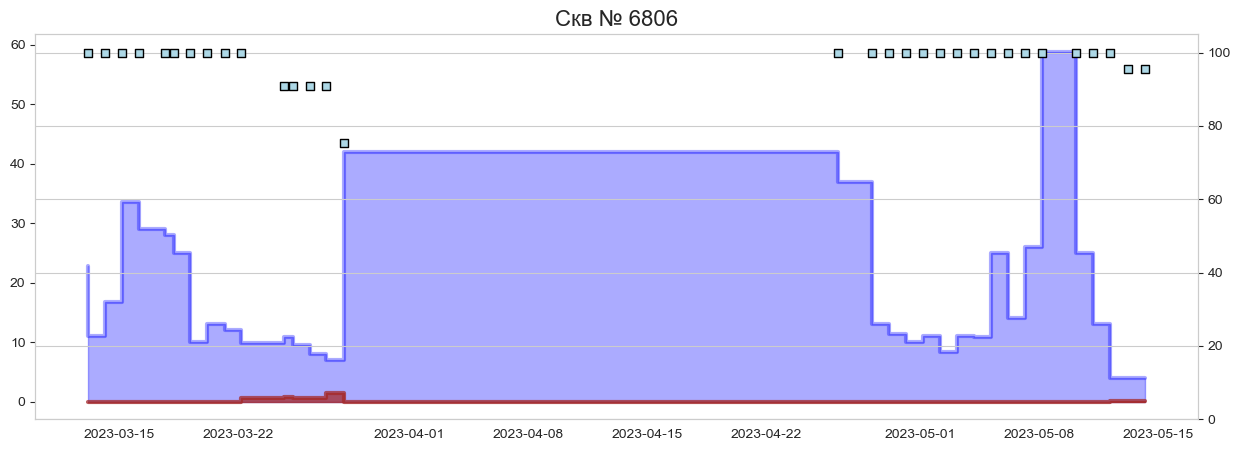

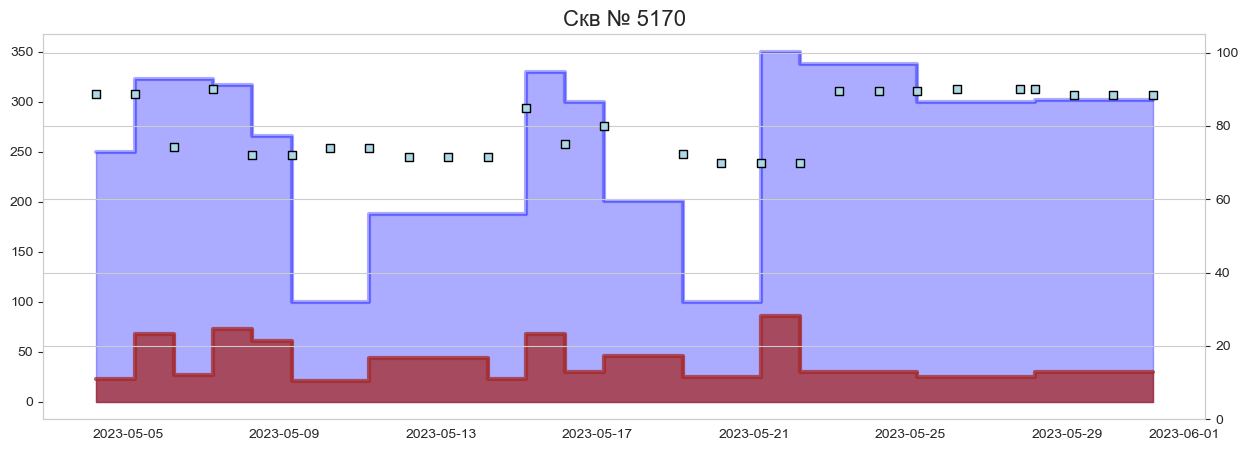

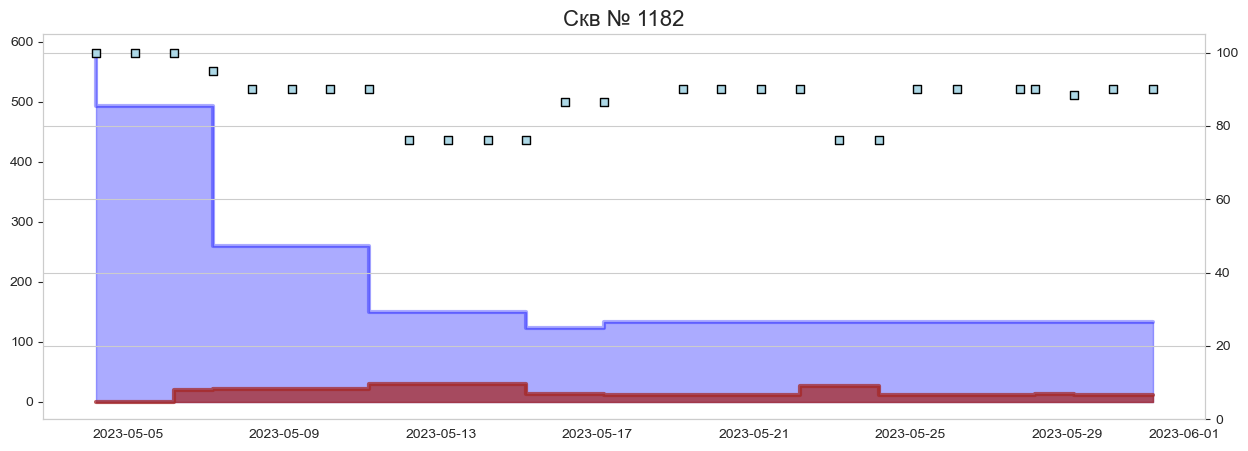

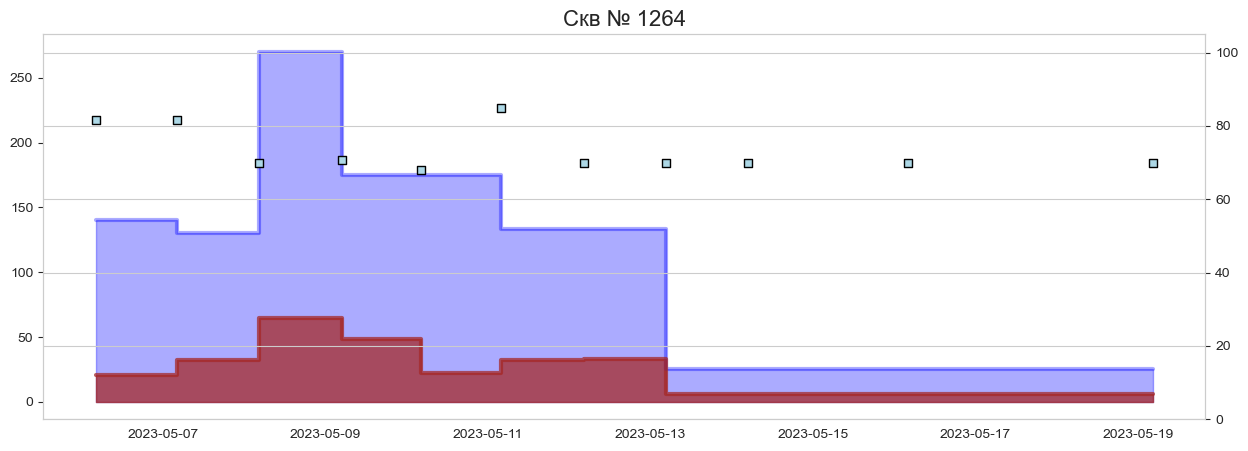

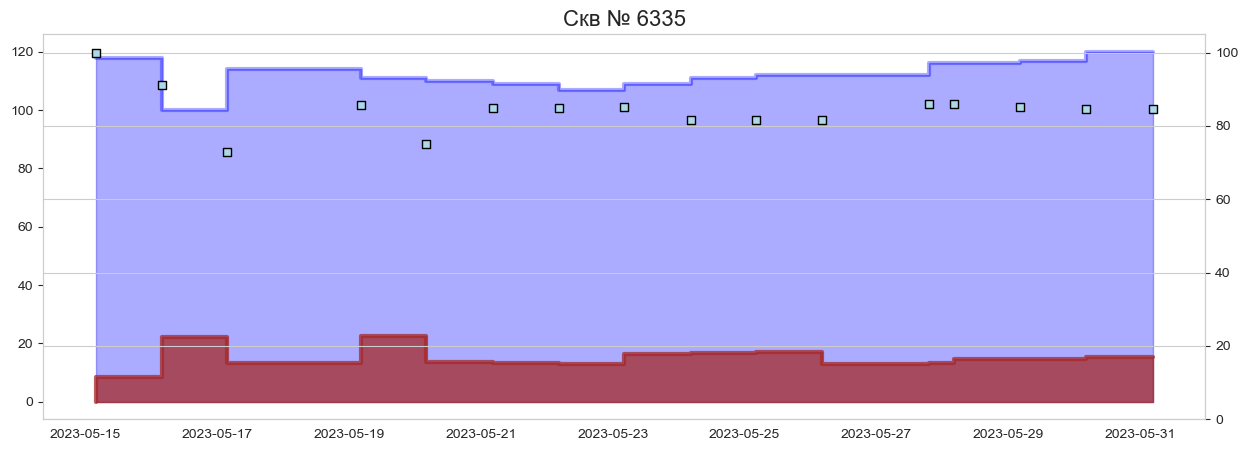

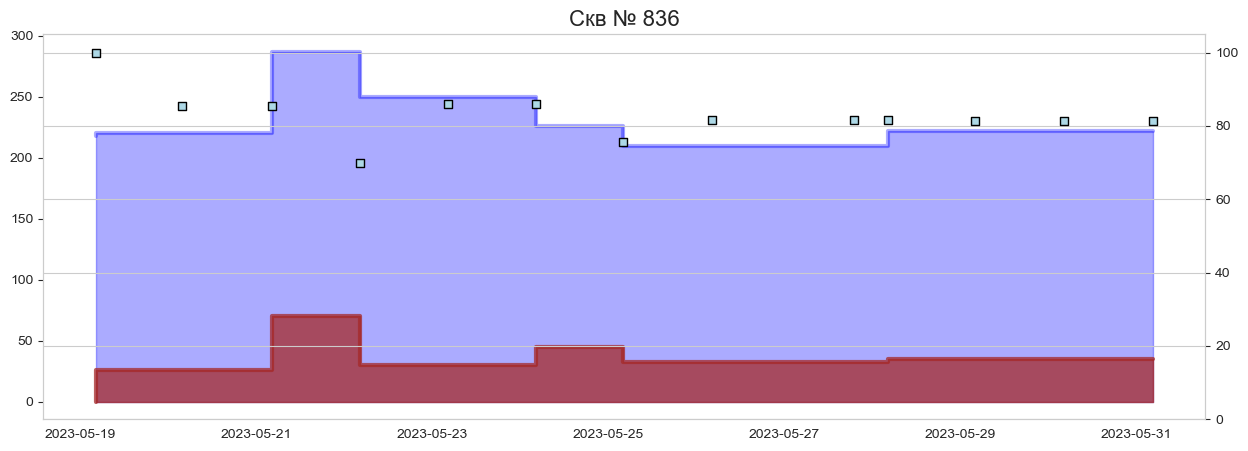

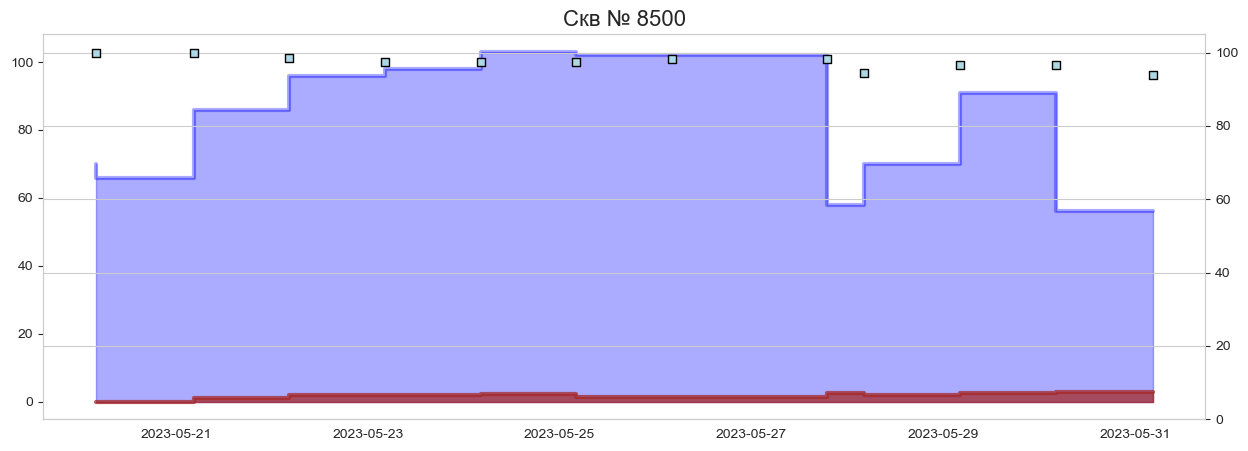

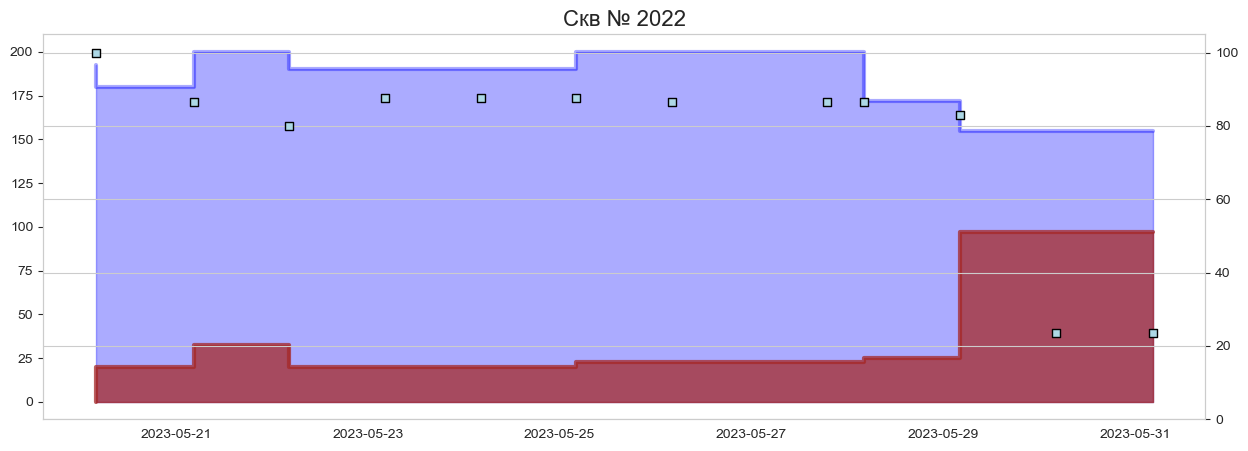

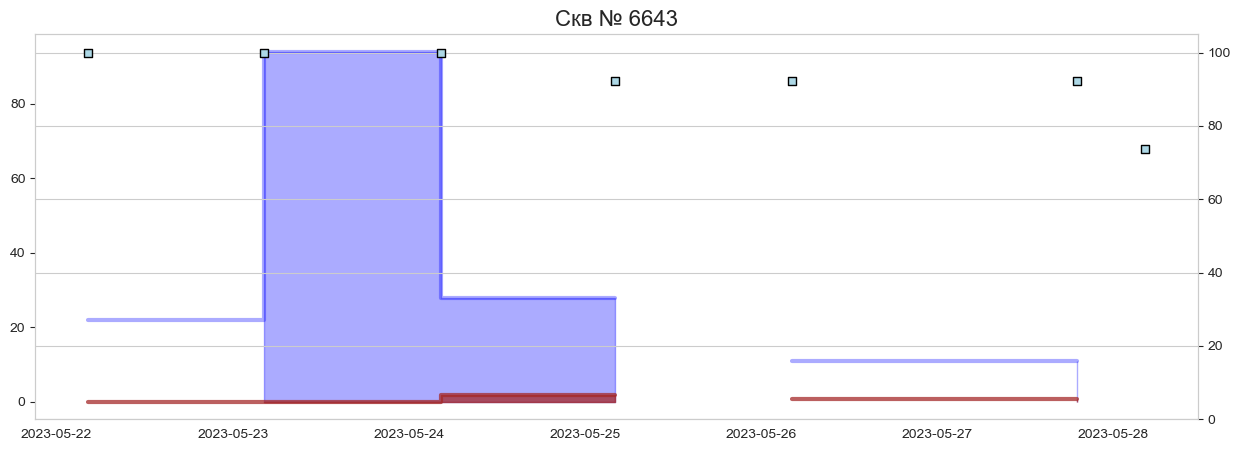

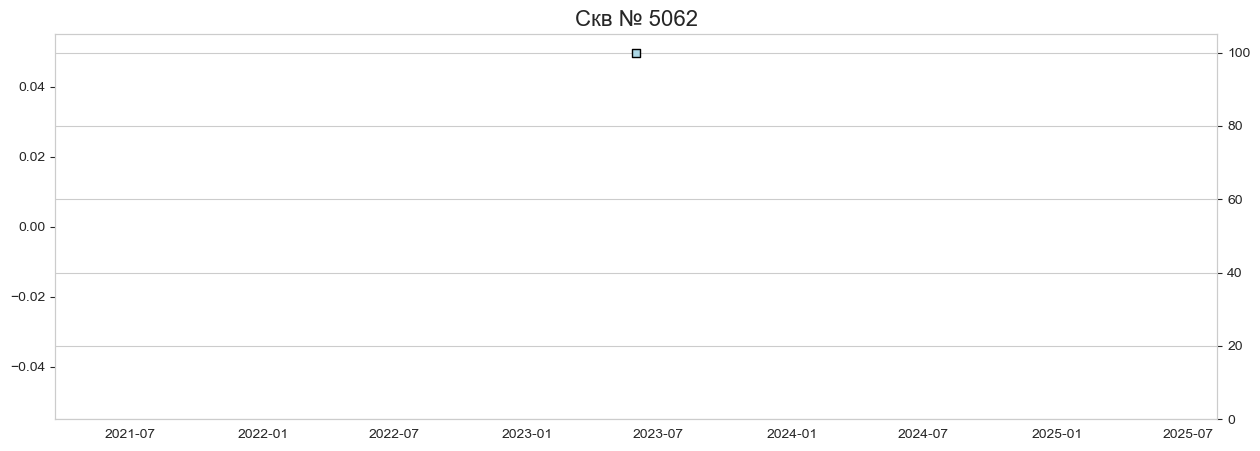

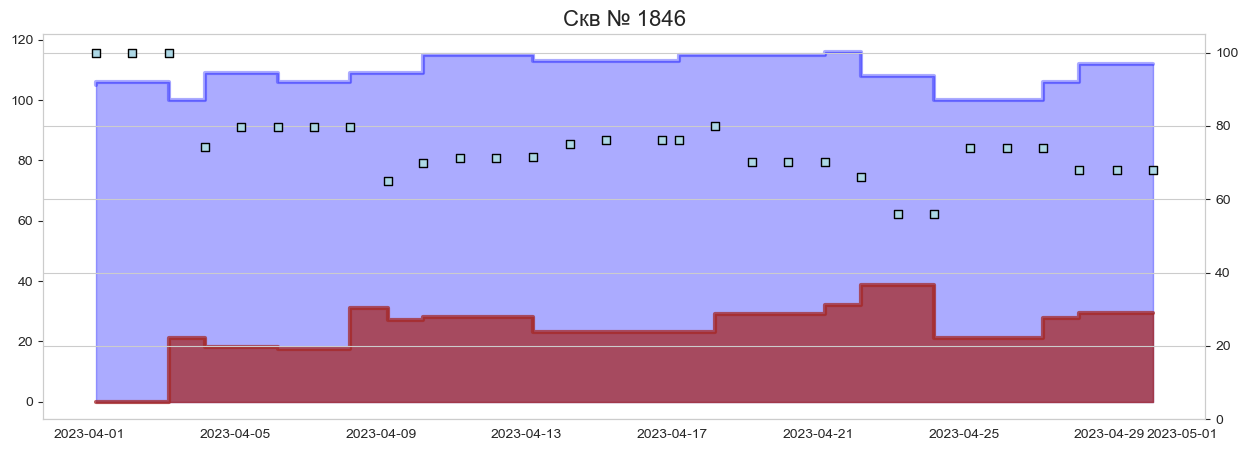

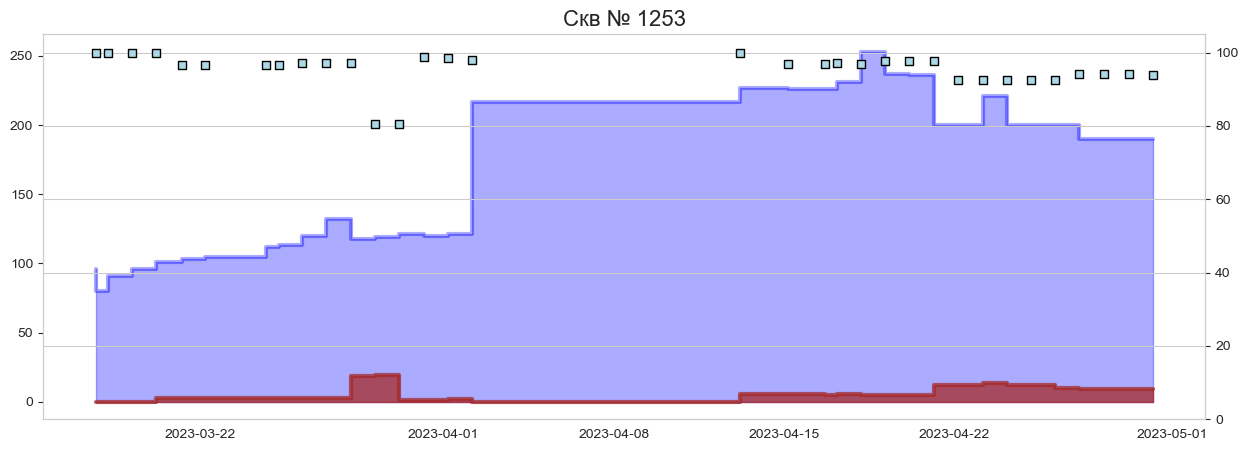

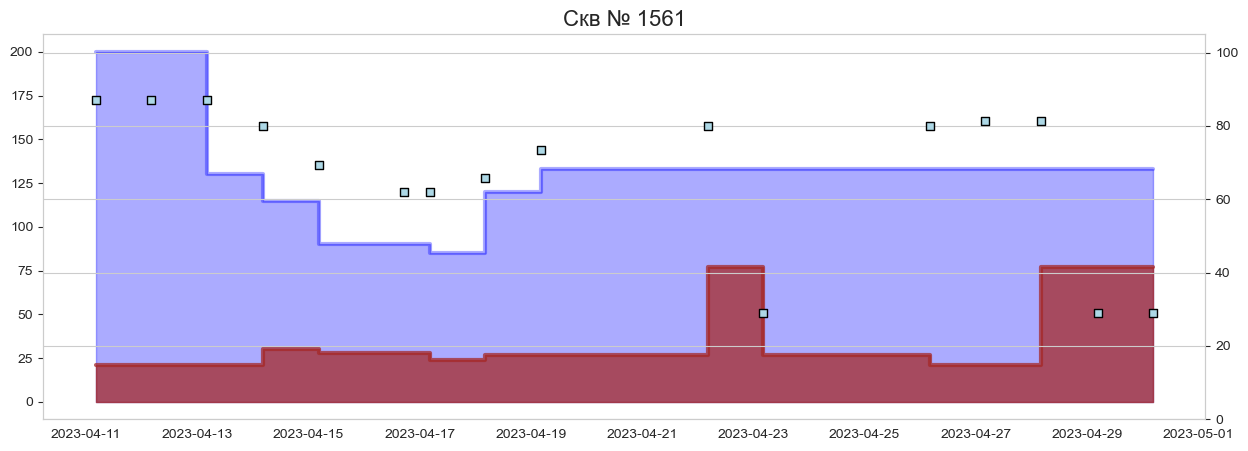

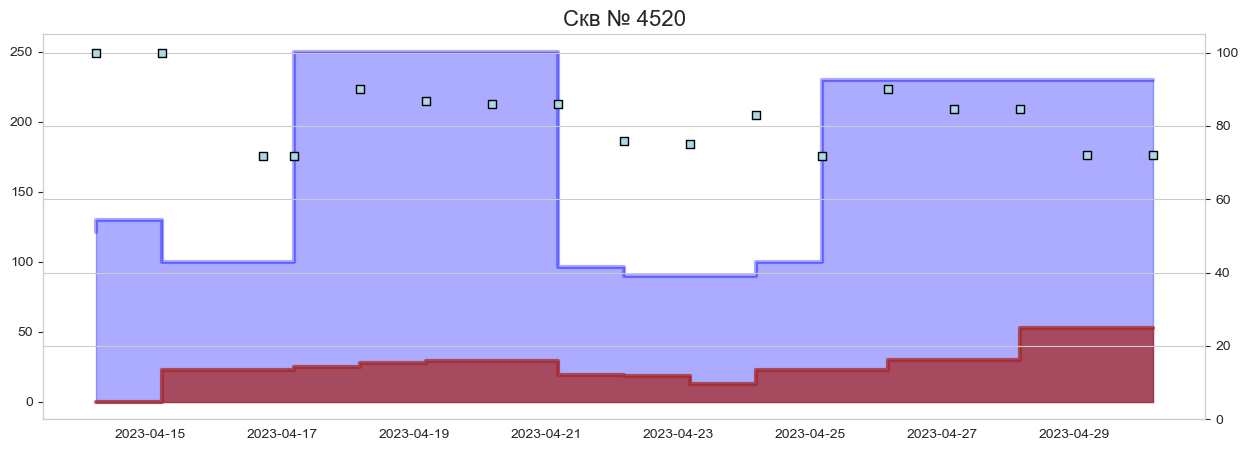

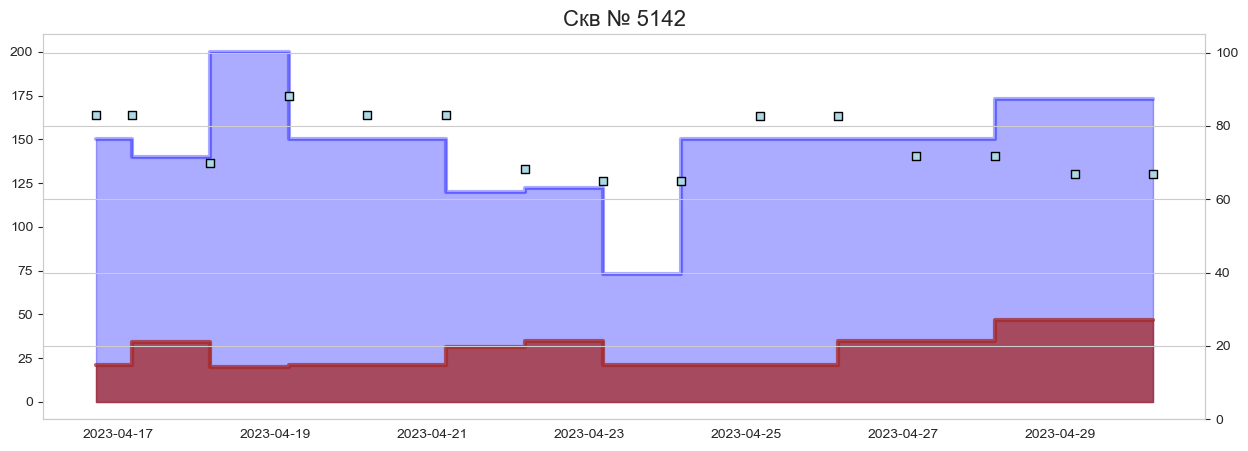

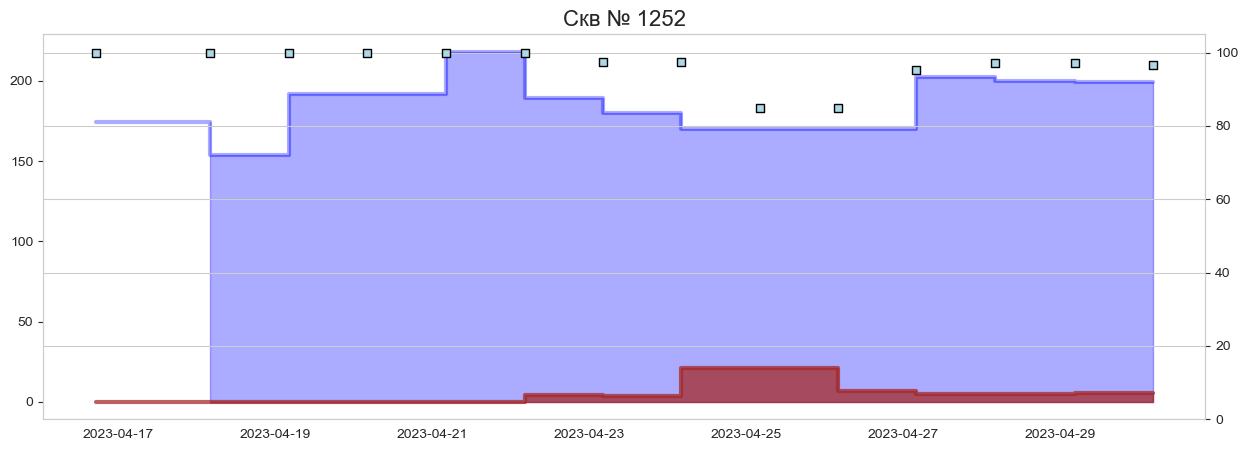

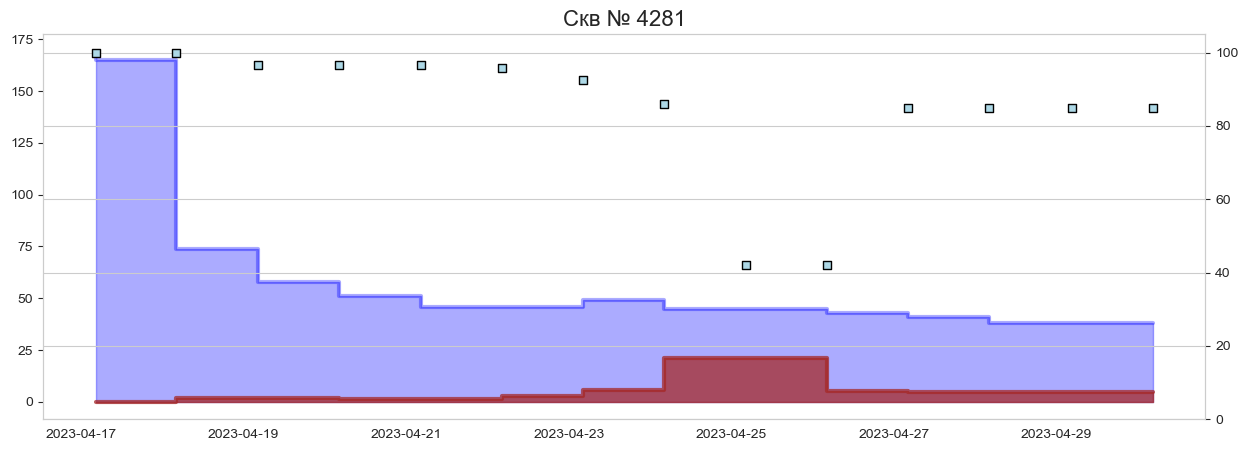

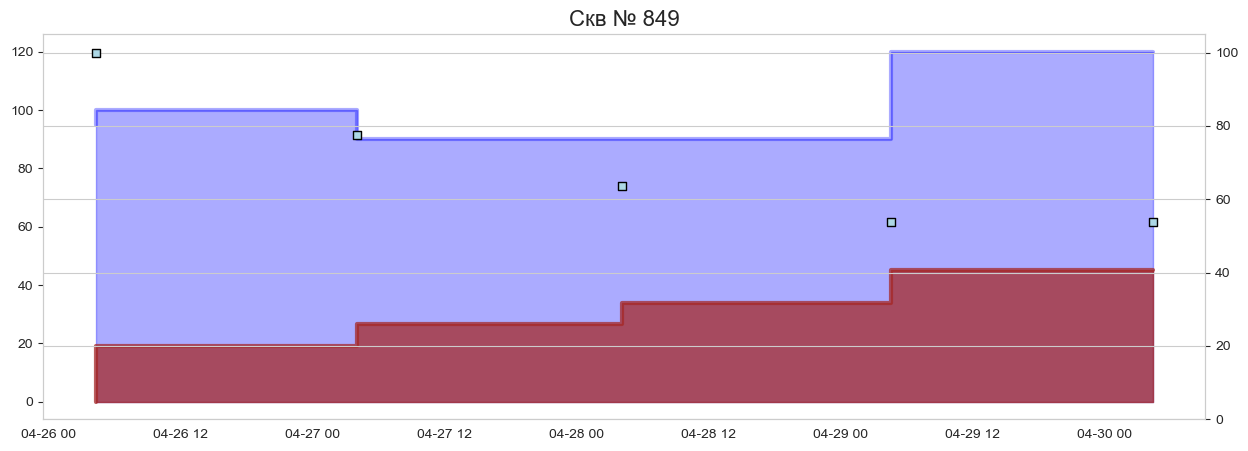

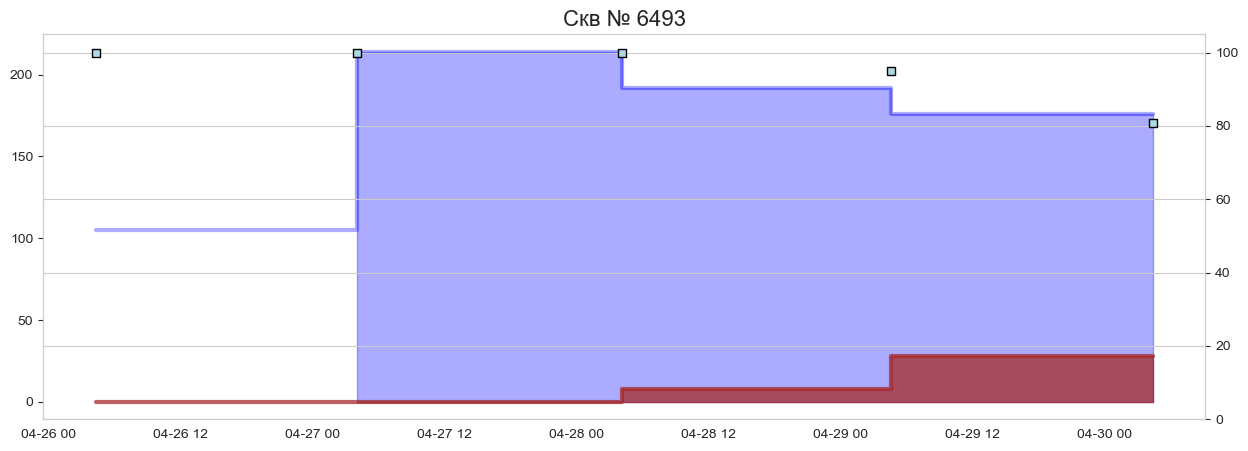

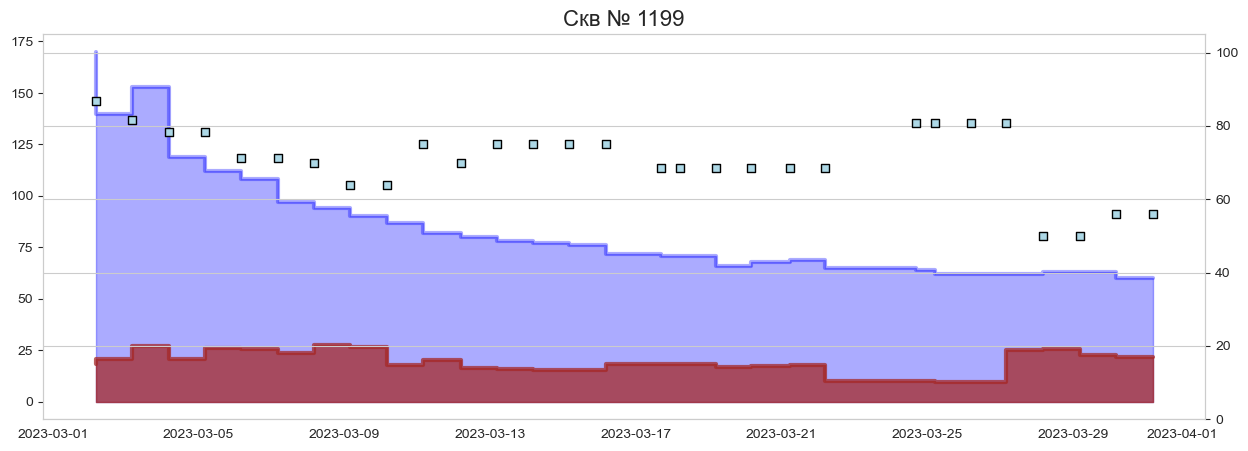

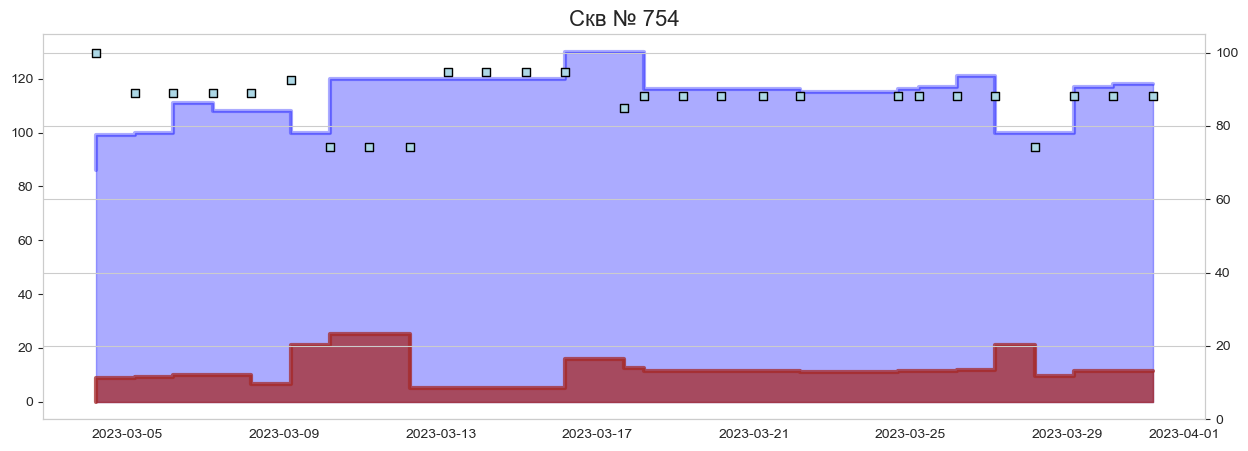

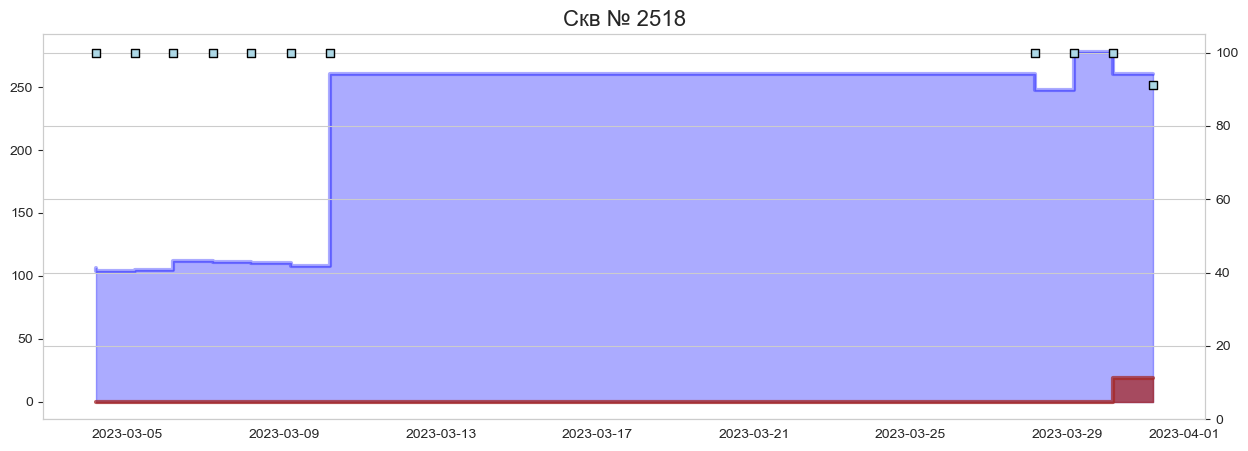

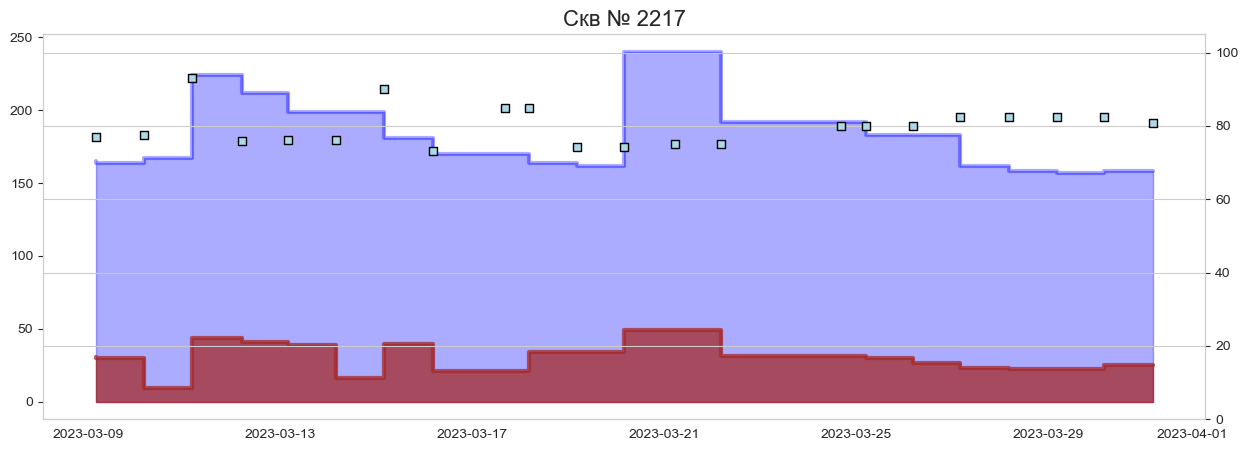

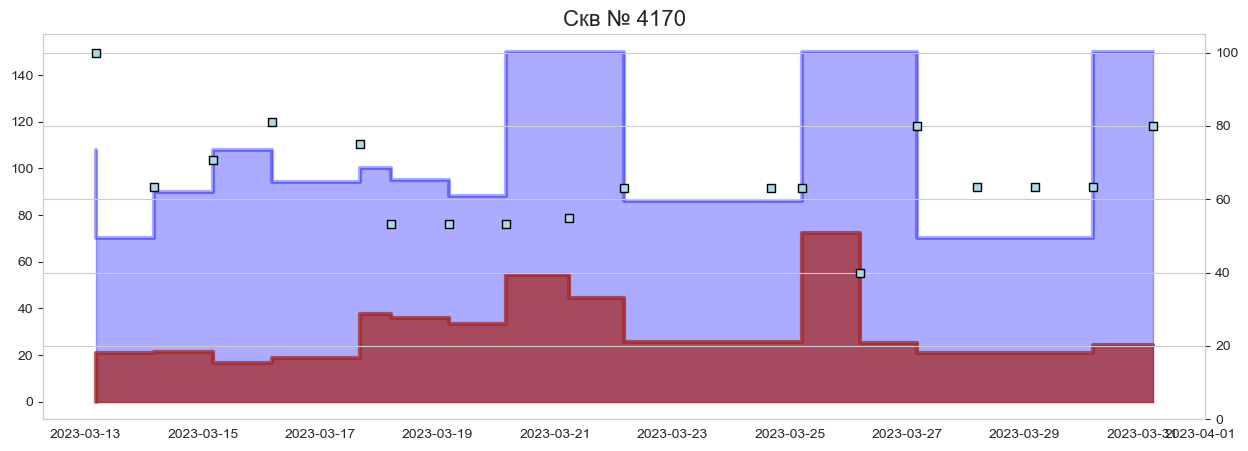

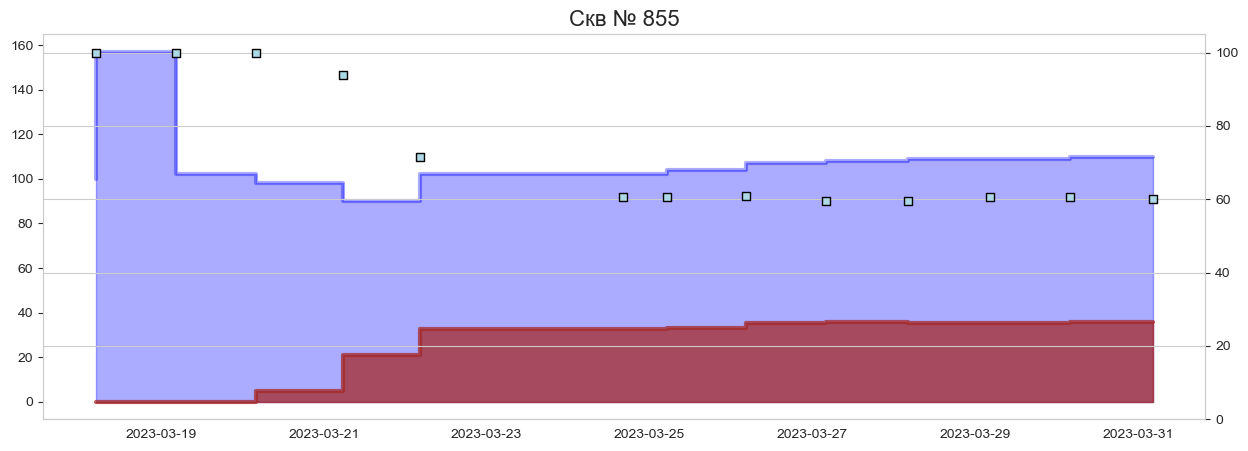

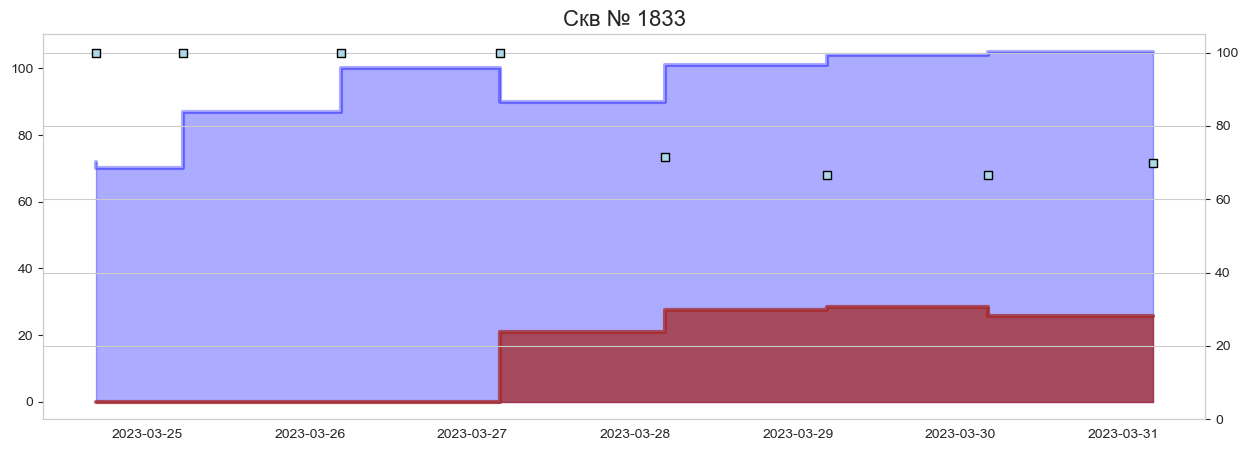

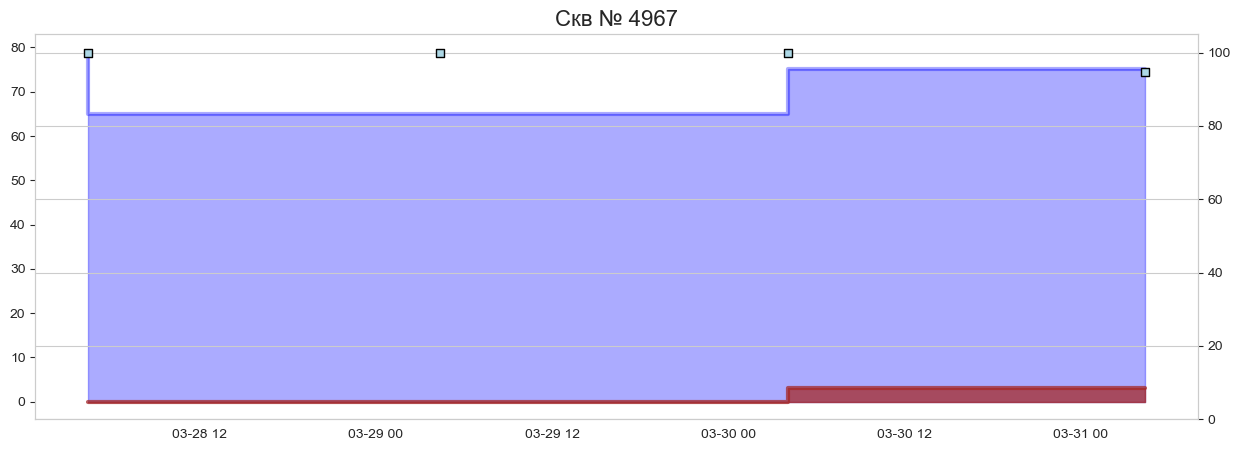

In [28]:
for wells in oilfield_wells['Скважина'].unique()[:]:
    f, ax = plt.subplots(figsize = (15,5))
    dates = oilfield_wells[oilfield_wells['Скважина'] == wells].sort_values(by=['Дата'])['Дата']
    oil = oilfield_wells[oilfield_wells['Скважина'] == wells].sort_values(by=['Дата'])['пар_раб_тн']
    wc = oilfield_wells[oilfield_wells['Скважина'] == wells].sort_values(by=['Дата'])['пар_раб_%']
    liq = oilfield_wells[oilfield_wells['Скважина'] == wells].sort_values(by=['Дата'])['пар_раб_м3']
    ax.step(dates, liq, color = 'blue', lw=3, alpha=0.33)
    ax.step(dates, oil, color = 'brown', lw=3, alpha=0.75)
    ax.fill_between(dates, liq, step='pre', alpha=0.33, color='blue')
    ax.fill_between(dates, oil, step='pre', alpha=0.75, color='brown')
    ax1 = ax.twinx()
    ax1.scatter(dates, wc, color = 'lightblue', marker='s', ec='black')
    ax1.set_ylim(0,105)
    ax.set_title('Скв № ' + wells, fontsize=16)
    ax.grid()